# Setup

In [1]:
import os
from pathlib import Path

os.chdir(Path.cwd().parent)
# print("cwd is now:", Path.cwd())

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from data_loader import scores_df
from fit import fit_statistical_model
import statsmodels.api as sm
from scipy.stats import linregress
from scipy.optimize import least_squares
from typing import Union, Optional

null performances after coercion: 0
after saturation filter 2452
after filter num benchmarks 2021
after merge with model versions 2017
after date filter (>= 2022-11-01) 1783
after merge with benchmark dates 1783
Original number of rows: 1783
Number of rows after aggregation: 1306


# Optimized

In [3]:
anchor_mode = "model"  # "model", "benchmark"
anchor_benchmark = "Winogrande"
anchor_difficulty = 0
anchor_slope = 1
anchor_model1 = "claude-3-opus-20240229"
anchor_model1_capability = 1.510032
anchor_model2 = "claude-opus-4-20250514"
anchor_model2_capability = 2.015441

opt_df = scores_df[scores_df["optimized"]]

df_opt, df_cm_opt, df_bd_opt = fit_statistical_model(
    # scores_df,
    opt_df,
    anchor_mode=anchor_mode,
    anchor_benchmark=anchor_benchmark,
    anchor_difficulty=anchor_difficulty,
    anchor_slope=anchor_slope,
    anchor_model1=anchor_model1,
    anchor_model1_capability=anchor_model1_capability,
    anchor_model2=anchor_model2,
    anchor_model2_capability=anchor_model2_capability,
)

df_cm_opt["date_obj"] = pd.to_datetime(df_cm_opt["date"])

`ftol` termination condition is satisfied.
Function evaluations 31, initial cost 4.0004e+01, final cost 2.5729e+00, first-order optimality 2.29e-04.


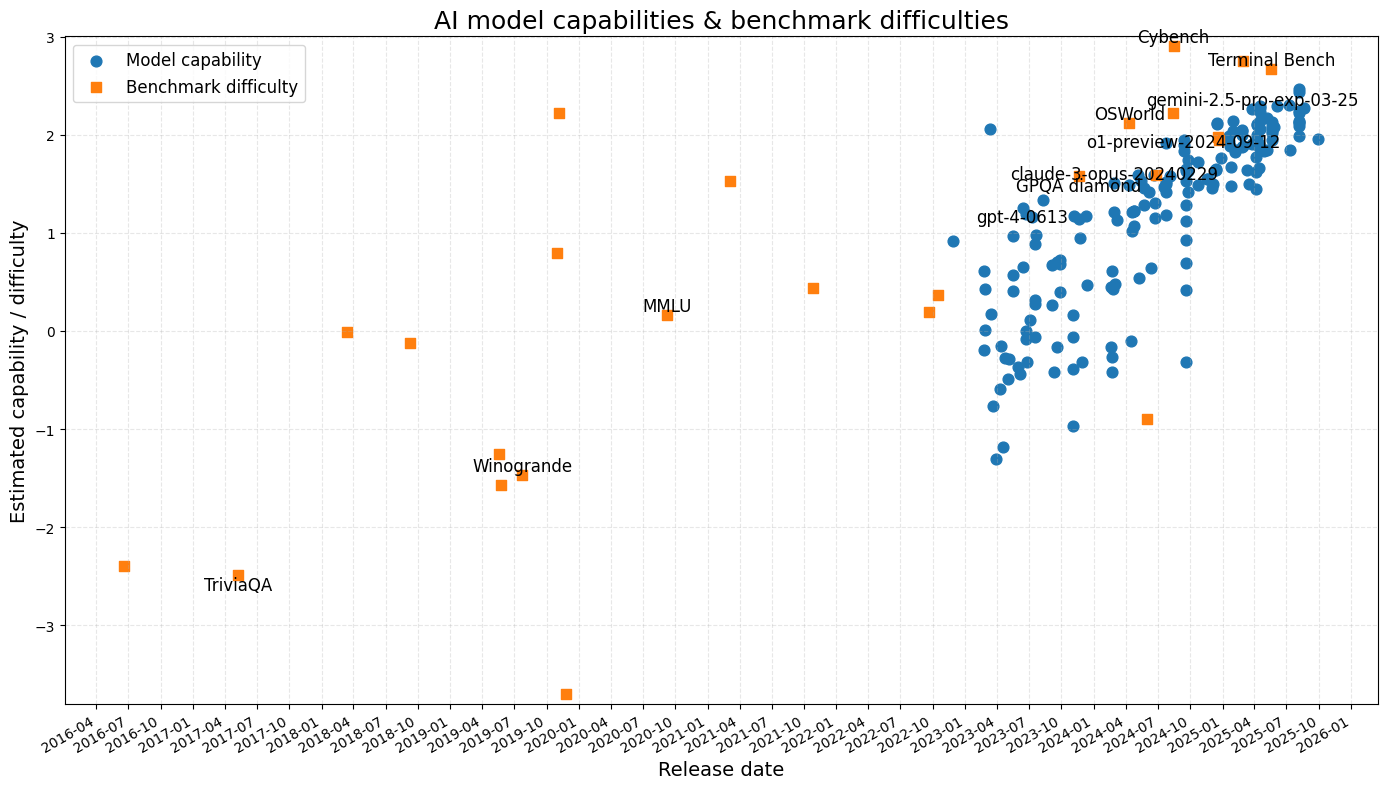

In [4]:
# ── 1)  PREP THE TWO DATA SETS ────────────────────────────────────────────
# --- models / capabilities
cap_df = df_cm_opt.copy()
cap_df["date_obj"] = pd.to_datetime(cap_df["date_obj"])
cap_df.sort_values("date_obj", inplace=True, ignore_index=True)
cap_dates_num = mdates.date2num(cap_df["date_obj"])
cap_values = cap_df["estimated_capability"]

# --- benchmarks / difficulties
bench_df = df_bd_opt.copy()
bench_df["date_obj"] = pd.to_datetime(bench_df["benchmark_release_date"])
bench_df.sort_values("date_obj", inplace=True, ignore_index=True)
bench_dates_num = mdates.date2num(bench_df["date_obj"])
bench_values = bench_df["estimated_difficulty"]

# ── 2)  PLOT BOTH SERIES ON ONE AXES ───────────────────────────────────────
fig, ax = plt.subplots(figsize=(14, 8))

cap_plot = ax.scatter(
    cap_dates_num,
    cap_values,
    marker="o",
    s=60,
    color="tab:blue",
    label="Model capability",
)
bench_plot = ax.scatter(
    bench_dates_num,
    bench_values,
    marker="s",
    s=60,
    color="tab:orange",
    label="Benchmark difficulty",
)

# ── 3)  ANNOTATE SELECTED POINTS ───────────────────────────────────────────
annotate_models = {
    "gpt-4-0613",
    "claude-3-opus-20240229",
    "gemini-2.5-pro-exp-03-25",
    "o1-preview-2024-09-12",
}

for i, (d, y, name) in enumerate(zip(cap_dates_num, cap_values, cap_df["model"])):
    if name not in annotate_models:
        continue
    y_offset = 0.05 if i % 2 == 0 else -0.05
    va = "bottom" if i % 2 == 0 else "top"
    ax.annotate(
        name,
        xy=(d, y),
        xytext=(0, y_offset),
        textcoords="offset points",
        ha="center",
        va=va,
        fontsize=12,
    )

annotate_benchmarks = {
    "MMLU",
    "Winogrande",
    "GPQA diamond",
    "OSWorld",
    "Cybench",
    "Terminal Bench",
    "TriviaQA",
}

for i, (d, y, name) in enumerate(
    zip(bench_dates_num, bench_values, bench_df["benchmark_name"])
):
    if name not in annotate_benchmarks:
        continue
    y_offset = 0.05 if i % 2 == 0 else -0.05
    va = "bottom" if i % 2 == 0 else "top"
    ax.annotate(
        name,
        xy=(d, y),
        xytext=(0, y_offset),
        textcoords="offset points",
        ha="center",
        va=va,
        fontsize=12,
    )

# ── 4)  AXES COSMETICS & LEGEND ────────────────────────────────────────────
ax.set_xlabel("Release date", fontsize=14)
ax.set_ylabel("Estimated capability / difficulty", fontsize=14)
ax.set_title("AI model capabilities & benchmark difficulties", fontsize=18)

# date ticks every 3 months
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
fig.autofmt_xdate()

# y-range covers both series
min_y = min(cap_values.min(), bench_values.min()) - 0.1
max_y = max(cap_values.max(), bench_values.max()) + 0.1
ax.set_ylim(min_y, max_y)

# x-range exactly as requested
# ax.set_xlim(datetime(2023, 1, 1), datetime(2025, 7, 1))

ax.grid(True, linestyle="--", alpha=0.3)
ax.legend(fontsize=12)

plt.tight_layout()
plt.savefig("capabilities_and_benchmarks_over_time.pdf")
plt.show()

[OPTIMIZED - Frontier] Annual growth rate: 0.3688
[OPTIMIZED - Frontier] 95% CI for slope: [0.1756, 0.5621]
[OPTIMIZED - Frontier] R^2: 0.6666
[OPTIMIZED - Frontier] Number of frontier models: 9


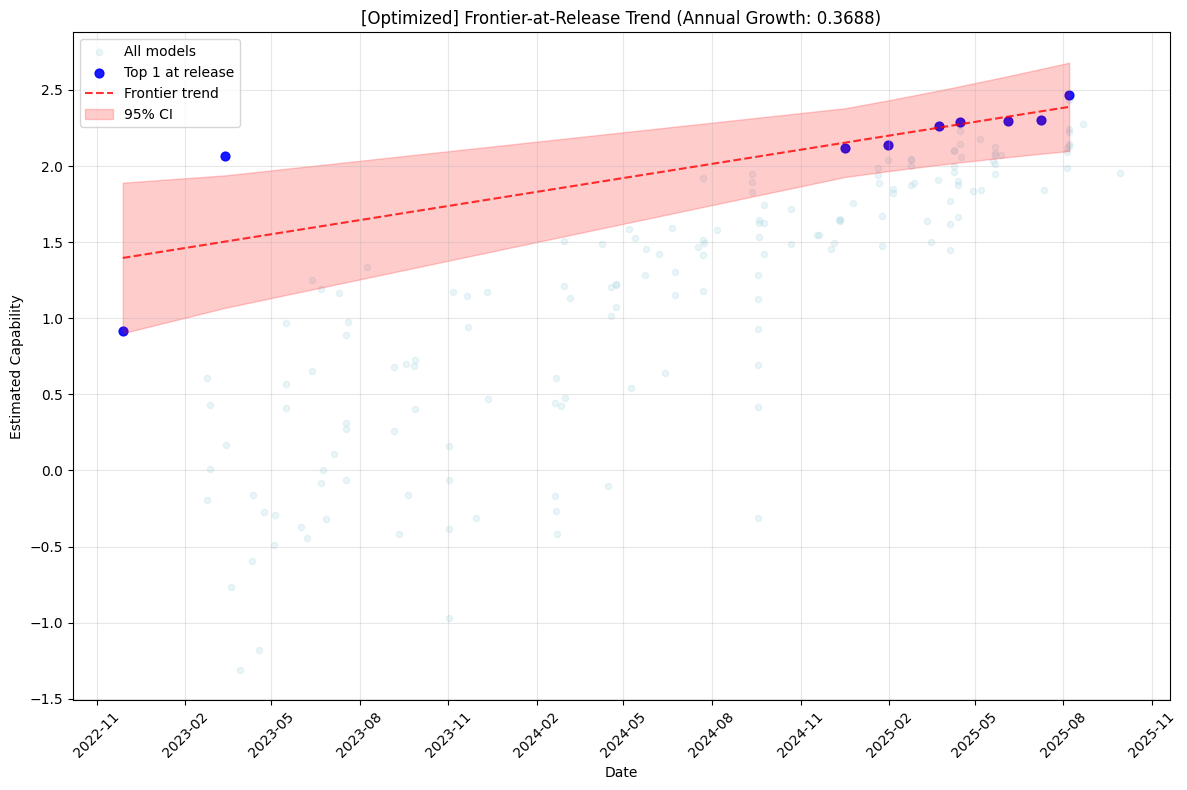

In [5]:
# ── 6) Frontier analysis for optimized benchmarks ─────────────────────────
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

TOP_N_AT_RELEASE = 1  # top-N frontier models (1 = strict SOTA)

# Prepare data for frontier analysis
df_all_opt = df_cm_opt.copy()
df_all_opt["date_obj"] = pd.to_datetime(df_all_opt["date_obj"])
df_all_opt = (
    df_all_opt.dropna(subset=["date_obj", "estimated_capability"])
    .sort_values("date_obj")
    .reset_index(drop=True)
)

# Compute frontier-at-release
frontier_rows_opt = []
for _, row in df_all_opt.iterrows():
    release_date = row["date_obj"]
    available = df_all_opt[df_all_opt["date_obj"] <= release_date]
    top_at_release = available.nlargest(TOP_N_AT_RELEASE, "estimated_capability")
    if row["model"] in top_at_release["model"].values:
        frontier_rows_opt.append(row)

df_frontier_opt = (
    pd.DataFrame(frontier_rows_opt).sort_values("date_obj").reset_index(drop=True)
)

# Fit linear trend through frontier points
if len(df_frontier_opt) >= 2:
    X = (
        df_frontier_opt["date_obj"] - df_frontier_opt["date_obj"].min()
    ).dt.days.values.reshape(-1, 1)
    y = df_frontier_opt["estimated_capability"].values
    lr = LinearRegression()
    lr.fit(X, y)
    slope_per_year = lr.coef_[0] * 365.25
    r2 = lr.score(X, y)

    # statsmodels for confidence intervals
    X_sm = sm.add_constant(X.flatten())
    model_sm = sm.OLS(y, X_sm).fit()
    predictions = model_sm.get_prediction(X_sm)
    ci_lower = predictions.conf_int()[:, 0]
    ci_upper = predictions.conf_int()[:, 1]

    # Print with CI
    print(f"[OPTIMIZED - Frontier] Annual growth rate: {slope_per_year:.4f}")
    print(
        f"[OPTIMIZED - Frontier] 95% CI for slope: [{model_sm.params[1]*365.25 - 1.96*model_sm.bse[1]*365.25:.4f}, "
        f"{model_sm.params[1]*365.25 + 1.96*model_sm.bse[1]*365.25:.4f}]"
    )
    print(f"[OPTIMIZED - Frontier] R^2: {r2:.4f}")
    print(f"[OPTIMIZED - Frontier] Number of frontier models: {len(df_frontier_opt)}")

    # Plot with confidence bands
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.scatter(
        df_all_opt["date_obj"],
        df_all_opt["estimated_capability"],
        alpha=0.25,
        s=20,
        label="All models",
        color="lightblue",
    )
    ax.scatter(
        df_frontier_opt["date_obj"],
        df_frontier_opt["estimated_capability"],
        alpha=0.9,
        s=40,
        label=f"Top {TOP_N_AT_RELEASE} at release",
        color="blue",
    )
    ax.plot(
        df_frontier_opt["date_obj"],
        lr.predict(X),
        "r--",
        alpha=0.8,
        label="Frontier trend",
    )

    # Add confidence band
    ax.fill_between(
        df_frontier_opt["date_obj"],
        ci_lower,
        ci_upper,
        alpha=0.2,
        color="red",
        label="95% CI",
    )

    ax.set_xlabel("Date")
    ax.set_ylabel("Estimated Capability")
    ax.set_title(
        f"[Optimized] Frontier-at-Release Trend (Annual Growth: {slope_per_year:.4f})"
    )
    ax.grid(True, alpha=0.3)
    ax.legend()
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("[OPTIMIZED - Frontier] Not enough frontier models for analysis")

Bootstrapped mean rate: 0.9487 capability units/year
95% confidence interval: [0.8350, 1.0648]


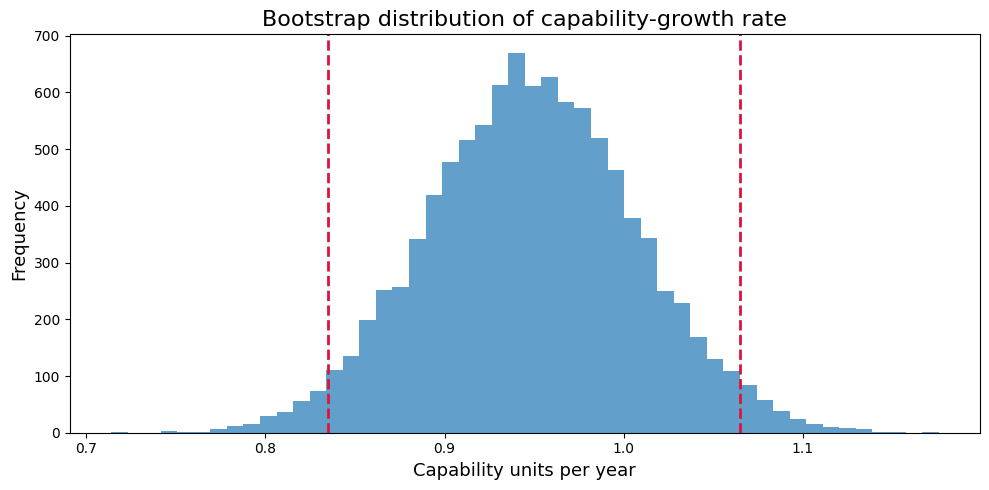

In [6]:
# ── 5) Bootstrap the slope ─────────────────────────────────────────────
import numpy as np

n_boot = 10000  # number of bootstrap resamples
rng = np.random.default_rng(0)  # reproducible seed

# filter out any non-finite dates/values (consistent with model_fit.ipynb)
mask = ~(np.isnan(cap_dates_num) | np.isnan(cap_values))
x_full = cap_dates_num[mask]  # days-since-0000-12-31 (float64)
y_full = cap_values[mask].to_numpy()  # capability values (float64)

boot_slopes_year = np.empty(n_boot)  # pre-allocate

for i in range(n_boot):
    # sample indices with replacement
    idx = rng.choice(len(x_full), len(x_full), replace=True)
    slope_day, _ = np.polyfit(x_full[idx], y_full[idx], 1)
    boot_slopes_year[i] = slope_day * 365.25  # convert to per-year

# point estimate & 95 % CI
mean_rate = boot_slopes_year.mean()
ci_lower, ci_upper = np.percentile(boot_slopes_year, [2.5, 97.5])

print(f"Bootstrapped mean rate: {mean_rate:.4f} capability units/year")
print(f"95% confidence interval: [{ci_lower:.4f}, {ci_upper:.4f}]")

# ── (optional) visualise the bootstrap distribution ────────────────────
plt.figure(figsize=(10, 5))
plt.hist(boot_slopes_year, bins=50, alpha=0.7)
plt.axvline(ci_lower, color="crimson", linestyle="--", lw=2)
plt.axvline(ci_upper, color="crimson", linestyle="--", lw=2)
plt.title("Bootstrap distribution of capability-growth rate", fontsize=16)
plt.xlabel("Capability units per year", fontsize=13)
plt.ylabel("Frequency", fontsize=13)
plt.tight_layout()
plt.show()

# Unoptimized

In [7]:
anchor_mode = "model"  # "model", "benchmark"
anchor_benchmark = "Balrog"
anchor_difficulty = 2.628412
anchor_slope = 1.233816
anchor_model1 = "claude-3-opus-20240229"
anchor_model1_capability = 1.510032
anchor_model2 = "claude-opus-4-20250514"
anchor_model2_capability = 2.015441

unopt_df = scores_df[~scores_df["optimized"]]

df_unopt, df_cm_unopt, df_bd_unopt = fit_statistical_model(
    unopt_df,
    anchor_mode=anchor_mode,
    anchor_benchmark=anchor_benchmark,
    anchor_difficulty=anchor_difficulty,
    anchor_slope=anchor_slope,
    anchor_model1=anchor_model1,
    anchor_model1_capability=anchor_model1_capability,
    anchor_model2=anchor_model2,
    anchor_model2_capability=anchor_model2_capability,
)

df_cm_unopt["date_obj"] = pd.to_datetime(df_cm_unopt["date"])

`ftol` termination condition is satisfied.
Function evaluations 32, initial cost 1.1424e+01, final cost 7.0014e-01, first-order optimality 7.34e-05.


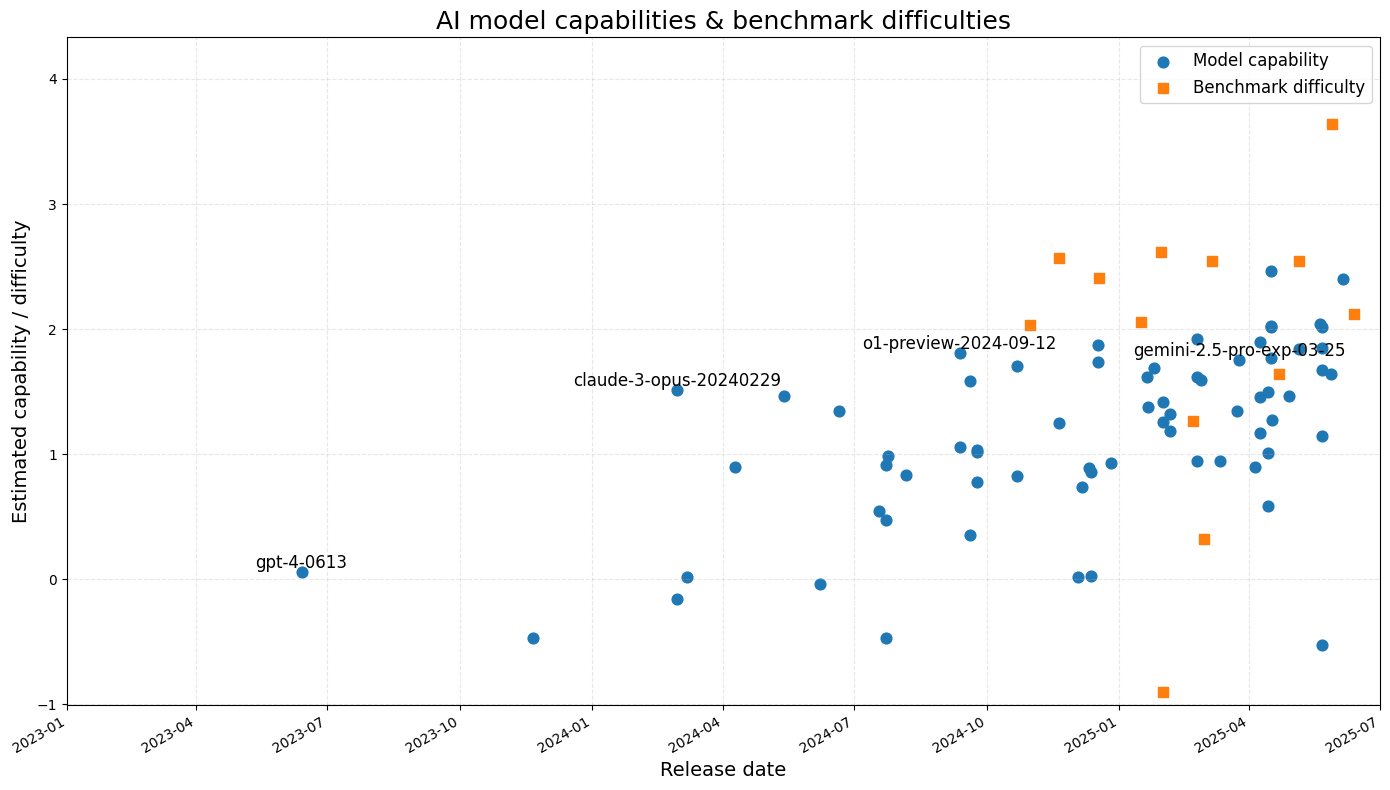

In [8]:
# ── 1)  PREP THE TWO DATA SETS ────────────────────────────────────────────
# --- models / capabilities
cap_df = df_cm_unopt.copy()
cap_df["date_obj"] = pd.to_datetime(cap_df["date_obj"])
cap_df.sort_values("date_obj", inplace=True, ignore_index=True)
cap_dates_num = mdates.date2num(cap_df["date_obj"])
cap_values = cap_df["estimated_capability"]

# --- benchmarks / difficulties
bench_df = df_bd_unopt.copy()
bench_df["date_obj"] = pd.to_datetime(bench_df["benchmark_release_date"])
bench_df.sort_values("date_obj", inplace=True, ignore_index=True)
bench_dates_num = mdates.date2num(bench_df["date_obj"])
bench_values = bench_df["estimated_difficulty"]

# ── 2)  PLOT BOTH SERIES ON ONE AXES ───────────────────────────────────────
fig, ax = plt.subplots(figsize=(14, 8))

cap_plot = ax.scatter(
    cap_dates_num,
    cap_values,
    marker="o",
    s=60,
    color="tab:blue",
    label="Model capability",
)
bench_plot = ax.scatter(
    bench_dates_num,
    bench_values,
    marker="s",
    s=60,
    color="tab:orange",
    label="Benchmark difficulty",
)

# ── 3)  ANNOTATE SELECTED POINTS ───────────────────────────────────────────
annotate_models = {
    "gpt-4-0613",
    "claude-3-opus-20240229",
    "gemini-2.5-pro-exp-03-25",
    "o1-preview-2024-09-12",
}

for i, (d, y, name) in enumerate(zip(cap_dates_num, cap_values, cap_df["model"])):
    if name not in annotate_models:
        continue
    y_offset = 0.05 if i % 2 == 0 else -0.05
    va = "bottom" if i % 2 == 0 else "top"
    ax.annotate(
        name,
        xy=(d, y),
        xytext=(0, y_offset),
        textcoords="offset points",
        ha="center",
        va=va,
        fontsize=12,
    )

annotate_benchmarks = {
    "MMLU",
    "Winogrande",
    "GPQA diamond",
    "OSWorld",
    "Cybench",
    "Terminal Bench",
    "TriviaQA",
}

for i, (d, y, name) in enumerate(
    zip(bench_dates_num, bench_values, bench_df["benchmark_name"])
):
    if name not in annotate_benchmarks:
        continue
    y_offset = 0.05 if i % 2 == 0 else -0.05
    va = "bottom" if i % 2 == 0 else "top"
    ax.annotate(
        name,
        xy=(d, y),
        xytext=(0, y_offset),
        textcoords="offset points",
        ha="center",
        va=va,
        fontsize=12,
    )

# ── 4)  AXES COSMETICS & LEGEND ────────────────────────────────────────────
ax.set_xlabel("Release date", fontsize=14)
ax.set_ylabel("Estimated capability / difficulty", fontsize=14)
ax.set_title("AI model capabilities & benchmark difficulties", fontsize=18)

# date ticks every 3 months
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
fig.autofmt_xdate()

# y-range covers both series
min_y = min(cap_values.min(), bench_values.min()) - 0.1
max_y = max(cap_values.max(), bench_values.max()) + 0.1
ax.set_ylim(min_y, max_y)

# x-range exactly as requested
ax.set_xlim(datetime(2023, 1, 1), datetime(2025, 7, 1))

ax.grid(True, linestyle="--", alpha=0.3)
ax.legend(fontsize=12)

plt.tight_layout()
plt.savefig("capabilities_and_benchmarks_over_time.pdf")
plt.show()

Bootstrapped mean rate: 0.9311 capability units/year
95% confidence interval: [0.6204, 1.2496]


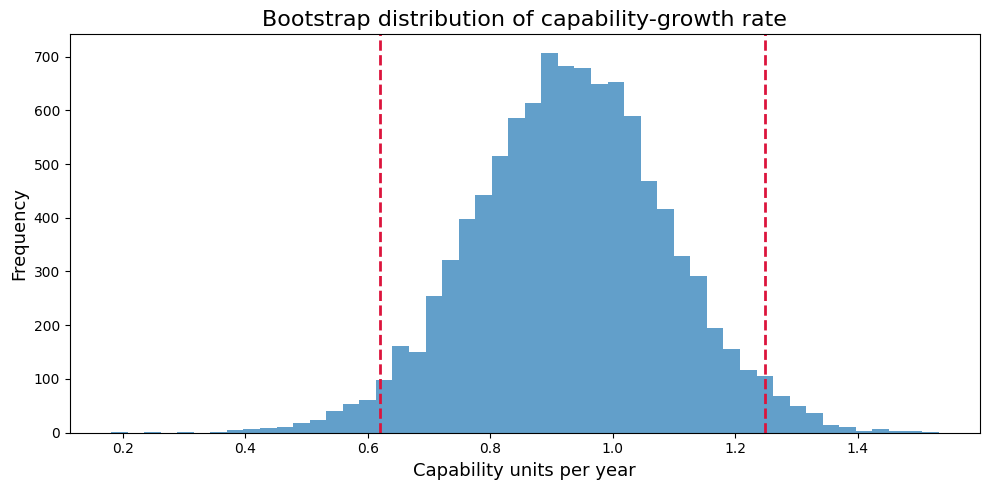

In [9]:
# ── 5) Bootstrap the slope ─────────────────────────────────────────────
n_boot = 10000  # number of bootstrap resamples
rng = np.random.default_rng(0)  # reproducible seed

# filter out any non-finite dates/values (consistent with model_fit.ipynb)
mask = ~(np.isnan(cap_dates_num) | np.isnan(cap_values))
x_full = cap_dates_num[mask]  # days-since-0000-12-31 (float64)
y_full = cap_values[mask].to_numpy()  # capability values (float64)

boot_slopes_year = np.empty(n_boot)  # pre-allocate

for i in range(n_boot):
    # sample indices with replacement
    idx = rng.choice(len(x_full), len(x_full), replace=True)
    slope_day, _ = np.polyfit(x_full[idx], y_full[idx], 1)
    boot_slopes_year[i] = slope_day * 365.25  # convert to per-year

# point estimate & 95 % CI
mean_rate = boot_slopes_year.mean()
ci_lower, ci_upper = np.percentile(boot_slopes_year, [2.5, 97.5])

print(f"Bootstrapped mean rate: {mean_rate:.4f} capability units/year")
print(f"95% confidence interval: [{ci_lower:.4f}, {ci_upper:.4f}]")

# ── (optional) visualise the bootstrap distribution ────────────────────
plt.figure(figsize=(10, 5))
plt.hist(boot_slopes_year, bins=50, alpha=0.7)
plt.axvline(ci_lower, color="crimson", linestyle="--", lw=2)
plt.axvline(ci_upper, color="crimson", linestyle="--", lw=2)
plt.title("Bootstrap distribution of capability-growth rate", fontsize=16)
plt.xlabel("Capability units per year", fontsize=13)
plt.ylabel("Frequency", fontsize=13)
plt.tight_layout()
plt.show()

[UNOPTIMIZED - Frontier] Annual growth rate: 1.1847
[UNOPTIMIZED - Frontier] 95% CI for slope: [0.8802, 1.4891]
[UNOPTIMIZED - Frontier] R^2: 0.9209
[UNOPTIMIZED - Frontier] Number of frontier models: 7


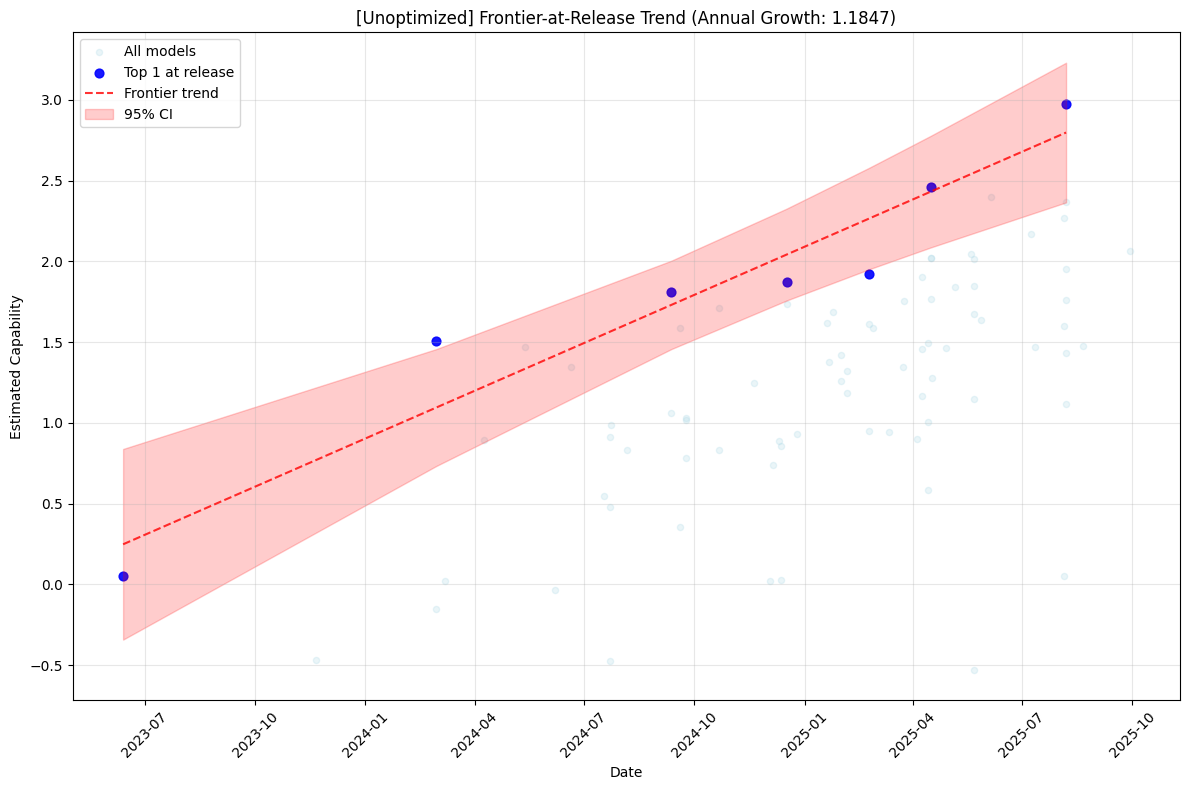

In [10]:
# ── 11) Frontier analysis for unoptimized benchmarks ──────────────────────
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

TOP_N_AT_RELEASE = 1  # top-N frontier models (1 = strict SOTA)

# Prepare data for frontier analysis
df_all_unopt = df_cm_unopt.copy()
df_all_unopt["date_obj"] = pd.to_datetime(df_all_unopt["date_obj"])
df_all_unopt = (
    df_all_unopt.dropna(subset=["date_obj", "estimated_capability"])
    .sort_values("date_obj")
    .reset_index(drop=True)
)

# Compute frontier-at-release
frontier_rows_unopt = []
for _, row in df_all_unopt.iterrows():
    release_date = row["date_obj"]
    available = df_all_unopt[df_all_unopt["date_obj"] <= release_date]
    top_at_release = available.nlargest(TOP_N_AT_RELEASE, "estimated_capability")
    if row["model"] in top_at_release["model"].values:
        frontier_rows_unopt.append(row)

df_frontier_unopt = (
    pd.DataFrame(frontier_rows_unopt).sort_values("date_obj").reset_index(drop=True)
)

# Fit linear trend through frontier points
if len(df_frontier_unopt) >= 2:
    X = (
        df_frontier_unopt["date_obj"] - df_frontier_unopt["date_obj"].min()
    ).dt.days.values.reshape(-1, 1)
    y = df_frontier_unopt["estimated_capability"].values
    lr = LinearRegression()
    lr.fit(X, y)
    slope_per_year = lr.coef_[0] * 365.25
    r2 = lr.score(X, y)

    # statsmodels for confidence intervals
    X_sm = sm.add_constant(X.flatten())
    model_sm = sm.OLS(y, X_sm).fit()
    predictions = model_sm.get_prediction(X_sm)
    ci_lower = predictions.conf_int()[:, 0]
    ci_upper = predictions.conf_int()[:, 1]

    # Print with CI
    print(f"[UNOPTIMIZED - Frontier] Annual growth rate: {slope_per_year:.4f}")
    print(
        f"[UNOPTIMIZED - Frontier] 95% CI for slope: [{model_sm.params[1]*365.25 - 1.96*model_sm.bse[1]*365.25:.4f}, "
        f"{model_sm.params[1]*365.25 + 1.96*model_sm.bse[1]*365.25:.4f}]"
    )
    print(f"[UNOPTIMIZED - Frontier] R^2: {r2:.4f}")
    print(
        f"[UNOPTIMIZED - Frontier] Number of frontier models: {len(df_frontier_unopt)}"
    )

    # Plot with confidence bands
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.scatter(
        df_all_unopt["date_obj"],
        df_all_unopt["estimated_capability"],
        alpha=0.25,
        s=20,
        label="All models",
        color="lightblue",
    )
    ax.scatter(
        df_frontier_unopt["date_obj"],
        df_frontier_unopt["estimated_capability"],
        alpha=0.9,
        s=40,
        label=f"Top {TOP_N_AT_RELEASE} at release",
        color="blue",
    )
    ax.plot(
        df_frontier_unopt["date_obj"],
        lr.predict(X),
        "r--",
        alpha=0.8,
        label="Frontier trend",
    )

    # Add confidence band
    ax.fill_between(
        df_frontier_unopt["date_obj"],
        ci_lower,
        ci_upper,
        alpha=0.2,
        color="red",
        label="95% CI",
    )

    ax.set_xlabel("Date")
    ax.set_ylabel("Estimated Capability")
    ax.set_title(
        f"[Unoptimized] Frontier-at-Release Trend (Annual Growth: {slope_per_year:.4f})"
    )
    ax.grid(True, alpha=0.3)
    ax.legend()
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("[UNOPTIMIZED - Frontier] Not enough frontier models for analysis")

In [11]:
df_frontier_opt

,model_id,estimated_capability,model,is_anchor,Model,date,date_obj
0,m177,0.917311,text-davinci-003,False,GPT-3.5,2022-11-28,2022-11-28
1,m184,2.063872,gpt-4-0314,False,GPT-4,2023-03-14,2023-03-14
2,m35,2.117317,o1-2024-12-17_medium,False,o1,2024-12-17,2024-12-17
3,m45,2.135936,o3-mini-2025-01-31_high,False,o3-mini,2025-01-31,2025-01-31
4,m58,2.264932,gemini-2.5-pro-exp-03-25,False,Gemini 2.5 Pro,2025-03-25,2025-03-25
5,m67,2.291252,o3-2025-04-16_high,False,o3,2025-04-16,2025-04-16
6,m82,2.294516,gemini-2.5-pro-preview-06-05,False,Gemini 2.5 Pro,2025-06-05,2025-06-05
7,m1,2.301974,grok-4-0709,False,Grok 4,2025-07-09,2025-07-09
8,m90,2.467841,gpt-5-2025-08-07_medium,False,GPT-5,2025-08-07,2025-08-07


In [12]:
df_frontier_unopt

,model_id,estimated_capability,model,is_anchor,Model,date,date_obj
0,m16,0.055251,gpt-4-0613,False,GPT-4,2023-06-13,2023-06-13
1,m4,1.510032,claude-3-opus-20240229,True,Claude 3 Opus,2024-02-29,2024-02-29
2,m7,1.809906,o1-preview-2024-09-12,False,o1-preview,2024-09-12,2024-09-12
3,m35,1.875202,o1-2024-12-17_medium,False,o1,2024-12-17,2024-12-17
4,m50,1.924243,claude-3-7-sonnet-20250219_16K,False,Claude 3.7 Sonnet,2025-02-24,2025-02-24
5,m94,2.460784,o3-2025-04-16_medium,False,o3,2025-04-16,2025-04-16
6,m90,2.977426,gpt-5-2025-08-07_medium,False,GPT-5,2025-08-07,2025-08-07


# Comparison: Optimized vs Unoptimized Capability Estimates


In [13]:
len(opt_df["benchmark"].unique()), len(unopt_df["benchmark"].unique())

(25, 14)

In [14]:
# 0) Create reference fit with Winogrande to get baseline difficulties and slopes
print("Creating reference fit with Winogrande anchor...")
reference_anchor_benchmark = "Winogrande"
_, _, df_benchmark_params_ref = fit_statistical_model(
    scores_df,
    anchor_mode="benchmark",
    anchor_benchmark=reference_anchor_benchmark,
    anchor_difficulty=0,
    anchor_slope=1,
)
# Create lookup dictionaries for difficulties and slopes
benchmark_difficulty_lookup = dict(
    zip(
        df_benchmark_params_ref["benchmark_name"],
        df_benchmark_params_ref["estimated_difficulty"],
    )
)
benchmark_slope_lookup = dict(
    zip(
        df_benchmark_params_ref["benchmark_name"],
        df_benchmark_params_ref["estimated_slope"],
    )
)
print(f"✓ Reference fit complete with {len(benchmark_difficulty_lookup)} benchmarks\n")

# 1) Choose anchor groups via metadata (no model info)
O_anchors = (
    opt_df.groupby("benchmark")["model"]
    .nunique()
    .sort_values(ascending=False)
    .head(10)
    .index.tolist()
)
U_anchors = (
    unopt_df.groupby("benchmark")["model"]
    .nunique()
    .sort_values(ascending=False)
    .head(10)
    .index.tolist()
)
# Optionally match by release date/topic between O_anchors and U_anchors


def fit_once(df, anchor):
    # Get difficulty and slope from reference fit (Winogrande-based)
    # If anchor not in reference fit, fall back to 0.0 and 1.0
    anchor_difficulty = benchmark_difficulty_lookup.get(anchor, 0.0)
    anchor_slope = benchmark_slope_lookup.get(anchor, 1.0)

    _, df_cap, df_bench = fit_statistical_model(
        df,
        anchor_mode="benchmark",
        anchor_benchmark=anchor,
        anchor_difficulty=anchor_difficulty,
        anchor_slope=anchor_slope,
    )
    return df_cap, df_bench


# 2) Multiple fits per partition (different single-benchmark anchors)
fits_O = [fit_once(opt_df, a) for a in O_anchors]
fits_U = [fit_once(unopt_df, b) for b in U_anchors]


def center_by_benchmark_group(df_cap, df_bench, group_names, weights=None):
    s = df_bench[df_bench["benchmark_name"].isin(group_names)]["estimated_difficulty"]
    if weights is not None:
        s = (s * weights.loc[s.index]).sum() / weights.loc[s.index].sum()
    else:
        s = s.mean()  # or median for robustness
    df_cap = df_cap.copy()
    df_cap["cap_centered"] = df_cap["estimated_capability"] - s
    return df_cap[["model", "cap_centered"]].set_index("model")["cap_centered"]


# 3) Center each fit using only its partition’s anchor group
caps_O_centered = [center_by_benchmark_group(c, b, O_anchors) for (c, b) in fits_O]
caps_U_centered = [center_by_benchmark_group(c, b, U_anchors) for (c, b) in fits_U]

# 4) Average within partitions, then compare on overlapping models
avg_O = sum(caps_O_centered) / len(caps_O_centered)
avg_U = sum(caps_U_centered) / len(caps_U_centered)
overlap = avg_O.index.intersection(avg_U.index)
delta_per_model = avg_O.loc[overlap] - avg_U.loc[overlap]
overall_delta = delta_per_model.mean()  # or median/trimmed mean

Creating reference fit with Winogrande anchor...
`ftol` termination condition is satisfied.
Function evaluations 32, initial cost 4.5427e+01, final cost 3.4998e+00, first-order optimality 8.87e-04.
✓ Reference fit complete with 39 benchmarks

`ftol` termination condition is satisfied.
Function evaluations 33, initial cost 3.7478e+01, final cost 2.5162e+00, first-order optimality 7.37e-04.
`ftol` termination condition is satisfied.
Function evaluations 27, initial cost 3.7317e+01, final cost 2.5107e+00, first-order optimality 5.06e-04.
`ftol` termination condition is satisfied.
Function evaluations 26, initial cost 3.8149e+01, final cost 2.5031e+00, first-order optimality 3.91e-04.
`ftol` termination condition is satisfied.
Function evaluations 31, initial cost 3.7305e+01, final cost 2.5066e+00, first-order optimality 5.17e-04.
`ftol` termination condition is satisfied.
Function evaluations 33, initial cost 3.7468e+01, final cost 2.5159e+00, first-order optimality 8.14e-04.
`ftol` termi

In [15]:
# ── Compare model capabilities: Optimized vs Unoptimized datasets ──────────

# Merge the two capability datasets
comparison_df = df_cm_opt[["model", "estimated_capability", "date"]].merge(
    df_cm_unopt[["model", "estimated_capability"]],
    on="model",
    suffixes=("_opt", "_unopt"),
    how="inner",  # Only keep models that appear in both datasets
)

# Calculate the difference
comparison_df["capability_diff"] = (
    comparison_df["estimated_capability_opt"]
    - comparison_df["estimated_capability_unopt"]
)
comparison_df["capability_ratio"] = (
    comparison_df["estimated_capability_opt"]
    / comparison_df["estimated_capability_unopt"]
)

# Sort by absolute difference
comparison_df_sorted = comparison_df.sort_values(
    "capability_diff", ascending=False
).reset_index(drop=True)

print("=" * 80)
print("MODELS IN BOTH OPTIMIZED AND UNOPTIMIZED DATASETS")
print("=" * 80)
print(f"\nTotal models in optimized dataset: {len(df_cm_opt)}")
print(f"Total models in unoptimized dataset: {len(df_cm_unopt)}")
print(f"Models appearing in BOTH datasets: {len(comparison_df)}")

print(f"\n\nDIFFERENCE STATISTICS:")
print("-" * 80)
print(f"Mean difference (opt - unopt): {comparison_df['capability_diff'].mean():.4f}")
print(f"Median difference: {comparison_df['capability_diff'].median():.4f}")
print(f"Std dev of difference: {comparison_df['capability_diff'].std():.4f}")
print(f"Max positive difference: {comparison_df['capability_diff'].max():.4f}")
print(f"Max negative difference: {comparison_df['capability_diff'].min():.4f}")

print(f"\n\nRATIO STATISTICS:")
print("-" * 80)
print(f"Mean ratio (opt / unopt): {comparison_df['capability_ratio'].mean():.4f}")
print(f"Median ratio: {comparison_df['capability_ratio'].median():.4f}")

# Perform paired t-test
from scipy.stats import ttest_rel, wilcoxon

t_stat, t_pvalue = ttest_rel(
    comparison_df["estimated_capability_opt"],
    comparison_df["estimated_capability_unopt"],
)
w_stat, w_pvalue = wilcoxon(
    comparison_df["estimated_capability_opt"],
    comparison_df["estimated_capability_unopt"],
)

print(f"\n\nSTATISTICAL TESTS:")
print("-" * 80)
print(f"Paired t-test:")
print(f"  t-statistic: {t_stat:.4f}")
print(f"  p-value: {t_pvalue:.6f}")
print(
    f"  Interpretation: Capabilities are {'SIGNIFICANTLY DIFFERENT' if t_pvalue < 0.05 else 'NOT significantly different'} (α=0.05)"
)

print(f"\nWilcoxon signed-rank test (non-parametric):")
print(f"  statistic: {w_stat:.4f}")
print(f"  p-value: {w_pvalue:.6f}")
print(
    f"  Interpretation: Capabilities are {'SIGNIFICANTLY DIFFERENT' if w_pvalue < 0.05 else 'NOT significantly different'} (α=0.05)"
)

print(f"\n\nTOP 10 MODELS WITH LARGEST POSITIVE DIFFERENCE (higher on optimized):")
print("-" * 80)
for i, row in comparison_df_sorted.head(10).iterrows():
    print(
        f"{row['model']:45s} | Opt: {row['estimated_capability_opt']:.4f} | Unopt: {row['estimated_capability_unopt']:.4f} | Diff: +{row['capability_diff']:.4f}"
    )

print(f"\n\nTOP 10 MODELS WITH LARGEST NEGATIVE DIFFERENCE (higher on unoptimized):")
print("-" * 80)
for i, row in comparison_df_sorted.tail(10).iterrows():
    print(
        f"{row['model']:45s} | Opt: {row['estimated_capability_opt']:.4f} | Unopt: {row['estimated_capability_unopt']:.4f} | Diff: {row['capability_diff']:.4f}"
    )

print("=" * 80)

MODELS IN BOTH OPTIMIZED AND UNOPTIMIZED DATASETS

Total models in optimized dataset: 170
Total models in unoptimized dataset: 82
Models appearing in BOTH datasets: 82


DIFFERENCE STATISTICS:
--------------------------------------------------------------------------------
Mean difference (opt - unopt): 0.5896
Median difference: 0.5278
Std dev of difference: 0.5346
Max positive difference: 2.6537
Max negative difference: -0.5096


RATIO STATISTICS:
--------------------------------------------------------------------------------
Mean ratio (opt / unopt): 3.6235
Median ratio: 1.2880


STATISTICAL TESTS:
--------------------------------------------------------------------------------
Paired t-test:
  t-statistic: 9.9870
  p-value: 0.000000
  Interpretation: Capabilities are SIGNIFICANTLY DIFFERENT (α=0.05)

Wilcoxon signed-rank test (non-parametric):
  statistic: 101.0000
  p-value: 0.000000
  Interpretation: Capabilities are SIGNIFICANTLY DIFFERENT (α=0.05)


TOP 10 MODELS WITH LARGEST P

/var/folders/45/pl9l3y_s6x5cl1ghg85n103r0000gn/T/ipykernel_92161/1074183265.py:70: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax3.boxplot(


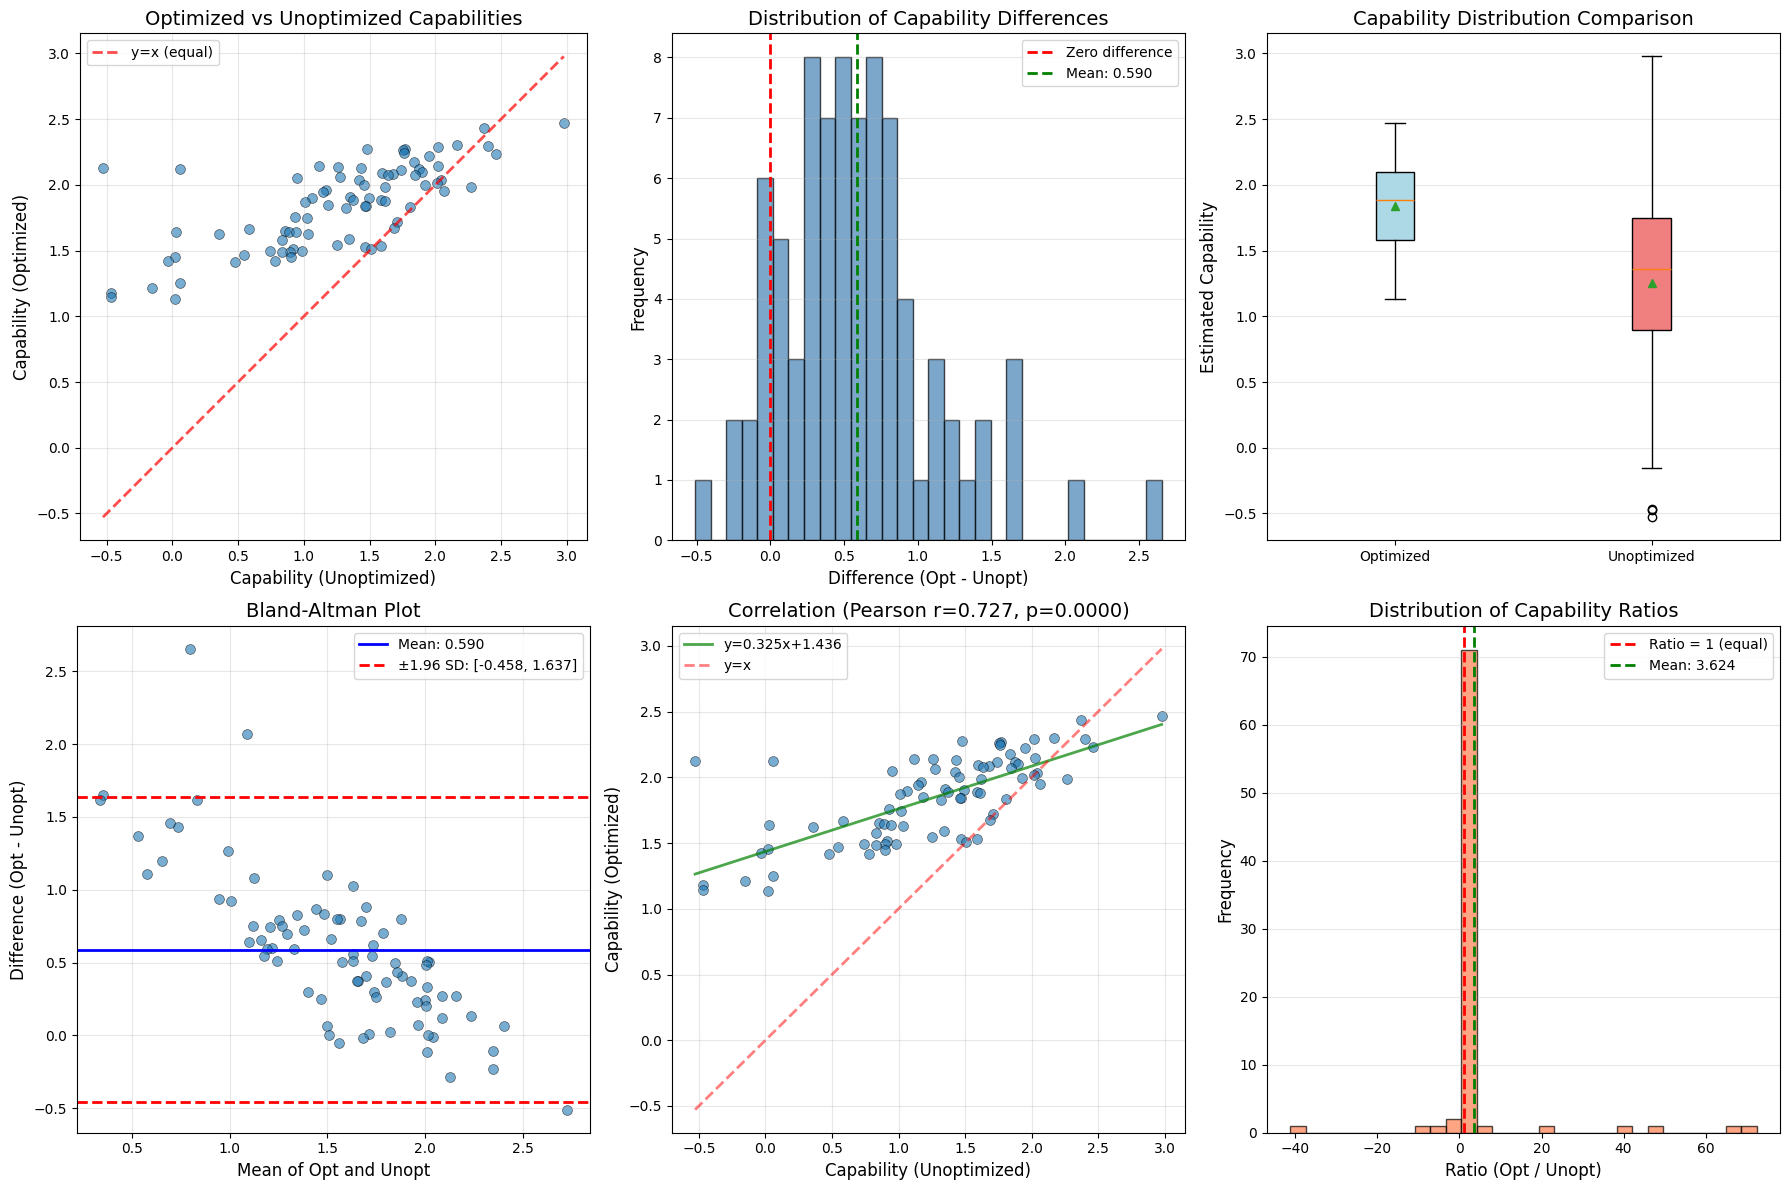


Correlation Statistics:
  Pearson correlation: r=0.7268, p=0.000000
  Spearman correlation: ρ=0.7245, p=0.000000


In [16]:
# ── Visualizations: Optimized vs Unoptimized Comparison ────────────────────

# Create a comprehensive comparison plot
fig = plt.figure(figsize=(18, 12))

# 1. Scatter plot: Optimized vs Unoptimized capabilities
ax1 = plt.subplot(2, 3, 1)
ax1.scatter(
    comparison_df["estimated_capability_unopt"],
    comparison_df["estimated_capability_opt"],
    alpha=0.6,
    s=50,
    edgecolors="black",
    linewidth=0.5,
)

# Add diagonal line (y=x)
min_val = min(
    comparison_df["estimated_capability_opt"].min(),
    comparison_df["estimated_capability_unopt"].min(),
)
max_val = max(
    comparison_df["estimated_capability_opt"].max(),
    comparison_df["estimated_capability_unopt"].max(),
)
ax1.plot(
    [min_val, max_val],
    [min_val, max_val],
    "r--",
    linewidth=2,
    alpha=0.7,
    label="y=x (equal)",
)
ax1.set_xlabel("Capability (Unoptimized)", fontsize=12)
ax1.set_ylabel("Capability (Optimized)", fontsize=12)
ax1.set_title("Optimized vs Unoptimized Capabilities", fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.legend()
ax1.set_aspect("equal", adjustable="box")

# 2. Histogram of differences
ax2 = plt.subplot(2, 3, 2)
ax2.hist(
    comparison_df["capability_diff"],
    bins=30,
    alpha=0.7,
    edgecolor="black",
    color="steelblue",
)
ax2.axvline(0, color="red", linestyle="--", linewidth=2, label="Zero difference")
ax2.axvline(
    comparison_df["capability_diff"].mean(),
    color="green",
    linestyle="--",
    linewidth=2,
    label=f'Mean: {comparison_df["capability_diff"].mean():.3f}',
)
ax2.set_xlabel("Difference (Opt - Unopt)", fontsize=12)
ax2.set_ylabel("Frequency", fontsize=12)
ax2.set_title("Distribution of Capability Differences", fontsize=14)
ax2.grid(True, alpha=0.3, axis="y")
ax2.legend()

# 3. Box plot comparison
ax3 = plt.subplot(2, 3, 3)
data_to_plot = [
    comparison_df["estimated_capability_opt"],
    comparison_df["estimated_capability_unopt"],
]
bp = ax3.boxplot(
    data_to_plot, labels=["Optimized", "Unoptimized"], patch_artist=True, showmeans=True
)
bp["boxes"][0].set_facecolor("lightblue")
bp["boxes"][1].set_facecolor("lightcoral")
ax3.set_ylabel("Estimated Capability", fontsize=12)
ax3.set_title("Capability Distribution Comparison", fontsize=14)
ax3.grid(True, alpha=0.3, axis="y")

# 4. Bland-Altman plot (difference vs average)
ax4 = plt.subplot(2, 3, 4)
mean_capabilities = (
    comparison_df["estimated_capability_opt"]
    + comparison_df["estimated_capability_unopt"]
) / 2
differences = comparison_df["capability_diff"]
mean_diff = differences.mean()
std_diff = differences.std()

ax4.scatter(
    mean_capabilities, differences, alpha=0.6, s=50, edgecolors="black", linewidth=0.5
)
ax4.axhline(
    mean_diff, color="blue", linestyle="-", linewidth=2, label=f"Mean: {mean_diff:.3f}"
)
ax4.axhline(
    mean_diff + 1.96 * std_diff,
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"±1.96 SD: [{mean_diff-1.96*std_diff:.3f}, {mean_diff+1.96*std_diff:.3f}]",
)
ax4.axhline(mean_diff - 1.96 * std_diff, color="red", linestyle="--", linewidth=2)
ax4.set_xlabel("Mean of Opt and Unopt", fontsize=12)
ax4.set_ylabel("Difference (Opt - Unopt)", fontsize=12)
ax4.set_title("Bland-Altman Plot", fontsize=14)
ax4.grid(True, alpha=0.3)
ax4.legend()

# 5. Correlation scatter with regression line
ax5 = plt.subplot(2, 3, 5)
from scipy.stats import pearsonr, spearmanr

r_pearson, p_pearson = pearsonr(
    comparison_df["estimated_capability_opt"],
    comparison_df["estimated_capability_unopt"],
)
r_spearman, p_spearman = spearmanr(
    comparison_df["estimated_capability_opt"],
    comparison_df["estimated_capability_unopt"],
)

ax5.scatter(
    comparison_df["estimated_capability_unopt"],
    comparison_df["estimated_capability_opt"],
    alpha=0.6,
    s=50,
    edgecolors="black",
    linewidth=0.5,
)

# Add regression line
z = np.polyfit(
    comparison_df["estimated_capability_unopt"],
    comparison_df["estimated_capability_opt"],
    1,
)
p = np.poly1d(z)
x_line = np.linspace(
    comparison_df["estimated_capability_unopt"].min(),
    comparison_df["estimated_capability_unopt"].max(),
    100,
)
ax5.plot(
    x_line, p(x_line), "g-", linewidth=2, alpha=0.7, label=f"y={z[0]:.3f}x+{z[1]:.3f}"
)
ax5.plot(
    [min_val, max_val], [min_val, max_val], "r--", linewidth=2, alpha=0.5, label="y=x"
)

ax5.set_xlabel("Capability (Unoptimized)", fontsize=12)
ax5.set_ylabel("Capability (Optimized)", fontsize=12)
ax5.set_title(
    f"Correlation (Pearson r={r_pearson:.3f}, p={p_pearson:.4f})", fontsize=14
)
ax5.grid(True, alpha=0.3)
ax5.legend()

# 6. Histogram of ratios
ax6 = plt.subplot(2, 3, 6)
ax6.hist(
    comparison_df["capability_ratio"],
    bins=30,
    alpha=0.7,
    edgecolor="black",
    color="coral",
)
ax6.axvline(1.0, color="red", linestyle="--", linewidth=2, label="Ratio = 1 (equal)")
ax6.axvline(
    comparison_df["capability_ratio"].mean(),
    color="green",
    linestyle="--",
    linewidth=2,
    label=f'Mean: {comparison_df["capability_ratio"].mean():.3f}',
)
ax6.set_xlabel("Ratio (Opt / Unopt)", fontsize=12)
ax6.set_ylabel("Frequency", fontsize=12)
ax6.set_title("Distribution of Capability Ratios", fontsize=14)
ax6.grid(True, alpha=0.3, axis="y")
ax6.legend()

plt.tight_layout()
plt.savefig("optimized_vs_unoptimized_comparison.pdf", dpi=300, bbox_inches="tight")
plt.show()

print(f"\nCorrelation Statistics:")
print(f"  Pearson correlation: r={r_pearson:.4f}, p={p_pearson:.6f}")
print(f"  Spearman correlation: ρ={r_spearman:.4f}, p={p_spearman:.6f}")

FileNotFoundError: [Errno 2] No such file or directory: 'outputs/notebooks/optimized_vs_unoptimized_labeled.pdf'

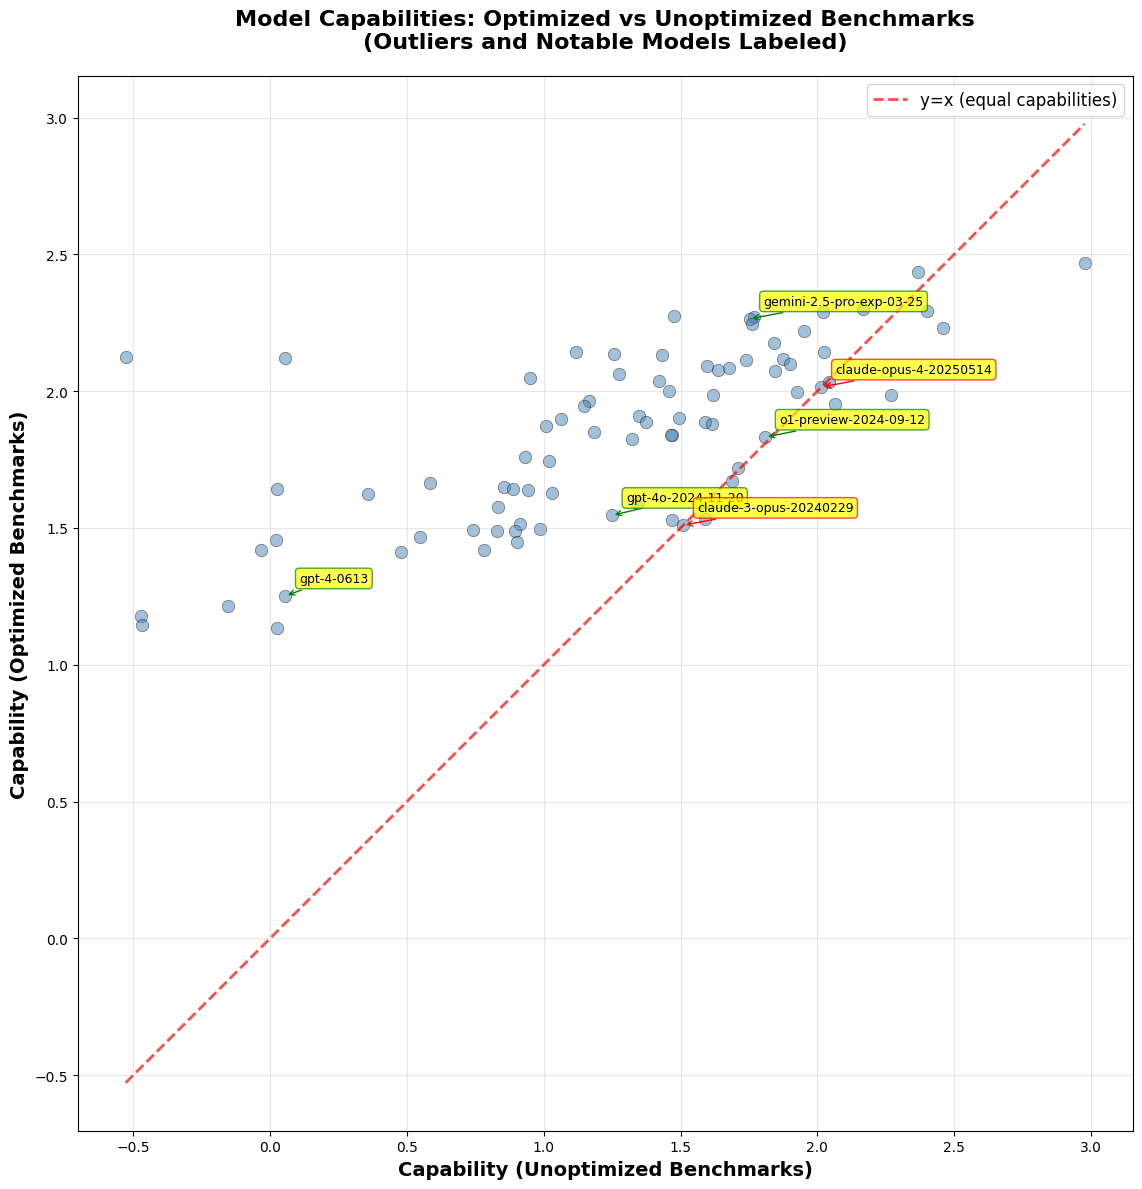

In [17]:
# ── Detailed scatter plot with model labels ────────────────────────────────

# Create scatter plot with model labels for outliers and notable models
fig, ax = plt.subplots(figsize=(16, 12))

# Scatter all points
ax.scatter(
    comparison_df["estimated_capability_unopt"],
    comparison_df["estimated_capability_opt"],
    alpha=0.5,
    s=80,
    edgecolors="black",
    linewidth=0.5,
    color="steelblue",
)

# Add diagonal line (y=x)
min_val = min(
    comparison_df["estimated_capability_opt"].min(),
    comparison_df["estimated_capability_unopt"].min(),
)
max_val = max(
    comparison_df["estimated_capability_opt"].max(),
    comparison_df["estimated_capability_unopt"].max(),
)
ax.plot(
    [min_val, max_val],
    [min_val, max_val],
    "r--",
    linewidth=2,
    alpha=0.7,
    label="y=x (equal capabilities)",
)

# Identify outliers (models with large differences)
threshold = comparison_df["capability_diff"].std() * 1.5
outliers = comparison_df[np.abs(comparison_df["capability_diff"]) > threshold]

# Also highlight some notable models
notable_models = [
    "gpt-4-0613",
    "claude-3-opus-20240229",
    "gemini-2.5-pro-exp-03-25",
    "o1-preview-2024-09-12",
    "gpt-4o-2024-11-20",
    "claude-opus-4-20250514",
]

# Combine outliers and notable models
models_to_label = pd.concat(
    [
        # outliers,
        comparison_df[comparison_df["model"].isin(notable_models)]
    ]
).drop_duplicates(subset="model")

# Label these models
for idx, row in models_to_label.iterrows():
    # Determine color based on difference
    color = "green" if row["capability_diff"] > 0 else "red"

    # Add arrow and label
    ax.annotate(
        row["model"],
        xy=(row["estimated_capability_unopt"], row["estimated_capability_opt"]),
        xytext=(10, 10),
        textcoords="offset points",
        fontsize=9,
        ha="left",
        bbox=dict(
            boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7, edgecolor=color
        ),
        arrowprops=dict(
            arrowstyle="->", connectionstyle="arc3,rad=0", lw=1, color=color
        ),
    )

ax.set_xlabel("Capability (Unoptimized Benchmarks)", fontsize=14, fontweight="bold")
ax.set_ylabel("Capability (Optimized Benchmarks)", fontsize=14, fontweight="bold")
ax.set_title(
    "Model Capabilities: Optimized vs Unoptimized Benchmarks\n(Outliers and Notable Models Labeled)",
    fontsize=16,
    fontweight="bold",
    pad=20,
)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=12)
ax.set_aspect("equal", adjustable="box")

plt.tight_layout()
plt.savefig(
    "outputs/notebooks/optimized_vs_unoptimized_labeled.pdf",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

print(f"\nLabeled {len(models_to_label)} models on the plot")
print(f"  - Outliers (|diff| > {threshold:.3f}): {len(outliers)}")
print(f"  - Notable models: {len(models_to_label) - len(outliers)}")

In [ ]:
# ── Export comparison data and summary insights ────────────────────────────

# Save the comparison DataFrame for further analysis
comparison_export = comparison_df[
    [
        "model",
        "date",
        "estimated_capability_opt",
        "estimated_capability_unopt",
        "capability_diff",
        "capability_ratio",
    ]
].copy()

comparison_export = comparison_export.sort_values("capability_diff", ascending=False)
comparison_export.to_csv(
    "outputs/model_capability_comparison_opt_vs_unopt.csv", index=False
)
print("Saved comparison data to: outputs/model_capability_comparison_opt_vs_unopt.csv")

# Summary insights
print("\n" + "=" * 80)
print("KEY INSIGHTS FROM COMPARISON")
print("=" * 80)

# Count models by direction of difference
higher_on_opt = len(comparison_df[comparison_df["capability_diff"] > 0])
higher_on_unopt = len(comparison_df[comparison_df["capability_diff"] < 0])
equal = len(comparison_df[comparison_df["capability_diff"] == 0])

print(f"\nDistribution of differences:")
print(
    f"  • Models with higher capability on OPTIMIZED benchmarks: {higher_on_opt} ({100*higher_on_opt/len(comparison_df):.1f}%)"
)
print(
    f"  • Models with higher capability on UNOPTIMIZED benchmarks: {higher_on_unopt} ({100*higher_on_unopt/len(comparison_df):.1f}%)"
)
print(f"  • Models with equal capability: {equal}")

# Statistical significance interpretation
print(f"\n\nStatistical interpretation:")
if t_pvalue < 0.001:
    print(f"  ✓ HIGHLY SIGNIFICANT difference (p < 0.001)")
elif t_pvalue < 0.05:
    print(f"  ✓ SIGNIFICANT difference (p < 0.05)")
else:
    print(f"  ✗ NO significant difference (p ≥ 0.05)")

mean_diff = comparison_df["capability_diff"].mean()
if abs(mean_diff) > 0.1:
    direction = "HIGHER on optimized" if mean_diff > 0 else "HIGHER on unoptimized"
    print(
        f"  • On average, models score {direction} benchmarks by {abs(mean_diff):.4f} capability units"
    )
else:
    print(f"  • On average, the difference is small ({mean_diff:.4f} capability units)")

# Correlation interpretation
if r_pearson > 0.9:
    print(
        f"\n  ✓ VERY STRONG correlation (r={r_pearson:.3f}) between opt and unopt capabilities"
    )
    print(
        f"    → Models that perform well on one type generally perform well on the other"
    )
elif r_pearson > 0.7:
    print(
        f"\n  ✓ STRONG correlation (r={r_pearson:.3f}) between opt and unopt capabilities"
    )
    print(f"    → Models show consistent performance across both benchmark types")
else:
    print(
        f"\n  ⚠ MODERATE correlation (r={r_pearson:.3f}) between opt and unopt capabilities"
    )
    print(f"    → Performance on one type doesn't strongly predict the other")

# Identify patterns
high_diff_models = comparison_df[
    comparison_df["capability_diff"] > comparison_df["capability_diff"].quantile(0.9)
]
print(f"\n\nModels with unusually high performance on optimized benchmarks:")
print(f"  (Top 10% by difference)")
for idx, row in high_diff_models.head(5).iterrows():
    print(f"  • {row['model']}: Δ = +{row['capability_diff']:.4f}")

low_diff_models = comparison_df[
    comparison_df["capability_diff"] < comparison_df["capability_diff"].quantile(0.1)
]
print(f"\n\nModels with unusually high performance on unoptimized benchmarks:")
print(f"  (Bottom 10% by difference)")
for idx, row in low_diff_models.head(5).iterrows():
    print(f"  • {row['model']}: Δ = {row['capability_diff']:.4f}")

print("\n" + "=" * 80)

Saved comparison data to: outputs/model_capability_comparison_opt_vs_unopt.csv

KEY INSIGHTS FROM COMPARISON

Distribution of differences:
  • Models with higher capability on OPTIMIZED benchmarks: 72 (87.8%)
  • Models with higher capability on UNOPTIMIZED benchmarks: 8 (9.8%)
  • Models with equal capability: 2


Statistical interpretation:
  ✓ HIGHLY SIGNIFICANT difference (p < 0.001)
  • On average, models score HIGHER on optimized benchmarks by 0.5896 capability units

  ✓ STRONG correlation (r=0.727) between opt and unopt capabilities
    → Models show consistent performance across both benchmark types


Models with unusually high performance on optimized benchmarks:
  (Top 10% by difference)
  • claude-sonnet-4-20250514_32K: Δ = +2.6537
  • claude-opus-4-1-20250805_27K: Δ = +2.0671
  • phi-4: Δ = +1.6164
  • qwen2.5-72b-instruct: Δ = +1.2684
  • amazon.nova-pro-v1:0: Δ = +1.4343


Models with unusually high performance on unoptimized benchmarks:
  (Bottom 10% by difference)
  • 

In [ ]:
# Random model-anchor pairs (Approach 1-style), initialized from a Claude3/Claude4 reference
# - Builds a reference model-anchored fit using Claude 3 & Claude 4
# - Samples N random model pairs; for each pair, fits both OPT and UNOPT sets in model-anchor mode
#   with anchor capabilities taken from the reference fit
# - Averages capabilities over the N pairs within each set, then reports opt − unopt delta

import numpy as np
import pandas as pd
from pathlib import Path
from itertools import combinations

# 0) Reference model-anchored fit using Claude 3 and Claude 4
CLAUDE3 = "claude-3-opus-20240229"
CLAUDE4 = "claude-opus-4-20250514"
# Use the same anchor capability scale you used earlier in the notebook
CLAUDE3_CAP = 1.510032
CLAUDE4_CAP = 2.015441

ref_df_m, ref_cm_m, _ = fit_statistical_model(
    scores_df,
    anchor_mode="model",
    anchor_model1=CLAUDE3,
    anchor_model1_capability=CLAUDE3_CAP,
    anchor_model2=CLAUDE4,
    anchor_model2_capability=CLAUDE4_CAP,
    random_state=0,
)
REF_C_BY_MODEL = dict(zip(ref_cm_m["model"], ref_cm_m["estimated_capability"]))
print(
    f"[reference model-anchored] cached capabilities for {len(REF_C_BY_MODEL)} models"
)


# 1) Helpers
def ensure_anchor_models_present(
    part_df: pd.DataFrame, anchor_model1: str, anchor_model2: str
) -> pd.DataFrame:
    need = []
    if anchor_model1 not in part_df["model"].values:
        need.append(anchor_model1)
    if anchor_model2 not in part_df["model"].values:
        need.append(anchor_model2)
    if not need:
        return part_df
    return pd.concat(
        [part_df, scores_df[scores_df["model"].isin(need)]], ignore_index=True
    )


def fit_with_model_anchors(df_subset: pd.DataFrame, m1: str, m2: str, seed: int = 0):
    # Pull fixed anchor capabilities from the reference map
    if m1 not in REF_C_BY_MODEL or m2 not in REF_C_BY_MODEL:
        raise ValueError(f"Missing reference capability for one of: {m1}, {m2}")
    cap1 = float(REF_C_BY_MODEL[m1])
    cap2 = float(REF_C_BY_MODEL[m2])
    _, df_cap, df_bench = fit_statistical_model(
        df_subset,
        anchor_mode="model",
        anchor_model1=m1,
        anchor_model1_capability=cap1,
        anchor_model2=m2,
        anchor_model2_capability=cap2,
        random_state=seed,
    )
    return df_cap, df_bench


def random_model_pairs(
    models: list[str], n_pairs: int, rng: np.random.Generator
) -> list[tuple[str, str]]:
    # sample without replacement over unordered pairs when possible; if not enough, sample with replacement fallback
    all_pairs = list(combinations(models, 2))
    if len(all_pairs) >= n_pairs:
        idx = rng.choice(len(all_pairs), size=n_pairs, replace=False)
        return [all_pairs[i] for i in idx]
    # fallback: sample with replacement
    pairs = []
    for _ in range(n_pairs):
        a, b = rng.choice(models, size=2, replace=False)
        pairs.append(tuple(sorted((a, b))))
    return pairs


# 2) Configure and run
N_PAIRS = 20  # number of random model-anchor pairs to try
SEED = 123

rng = np.random.default_rng(SEED)

# Candidate anchors: models that appear anywhere and have a reference capability
candidate_models = sorted(set(scores_df["model"]).intersection(REF_C_BY_MODEL.keys()))
pairs = random_model_pairs(candidate_models, N_PAIRS, rng)
print(f"Sampling {len(pairs)} random anchor pairs")

opt_df = scores_df[scores_df["optimized"]].copy()
unopt_df = scores_df[~scores_df["optimized"]].copy()

opt_caps_by_pair = []
unopt_caps_by_pair = []

skipped = 0
for i, (m1, m2) in enumerate(pairs, start=1):
    try:
        # Ensure anchors present in each partition
        opt_df_pair = ensure_anchor_models_present(opt_df, m1, m2)
        unopt_df_pair = ensure_anchor_models_present(unopt_df, m1, m2)

        # Fit both partitions with the SAME anchor pair (fixed caps from reference)
        cap_opt, _ = fit_with_model_anchors(opt_df_pair, m1, m2, seed=SEED + 2 * i)
        cap_unopt, _ = fit_with_model_anchors(
            unopt_df_pair, m1, m2, seed=SEED + 2 * i + 1
        )

        opt_caps_by_pair.append(cap_opt.set_index("model")["estimated_capability"])
        unopt_caps_by_pair.append(cap_unopt.set_index("model")["estimated_capability"])
    except Exception as e:
        skipped += 1
        # print(f"Skipped pair ({m1}, {m2}): {e}")
        continue

print(f"Completed: {len(opt_caps_by_pair)} pairs; skipped: {skipped}")


# 3) Average across pairs within each set (Approach 1-style)
def _avg(series_list: list[pd.Series]) -> pd.Series:
    if not series_list:
        return pd.Series(dtype=float)
    return pd.concat(series_list, axis=1).mean(axis=1)


opt_avg_pairs = _avg(opt_caps_by_pair).rename("opt_avg_modelAnchPairs")
unopt_avg_pairs = _avg(unopt_caps_by_pair).rename("unopt_avg_modelAnchPairs")

# 4) Compare on overlapping models
overlap_models = opt_avg_pairs.index.intersection(unopt_avg_pairs.index)
delta_pairs = opt_avg_pairs.loc[overlap_models] - unopt_avg_pairs.loc[overlap_models]

summary_pairs = {
    "n_pairs_used": len(opt_caps_by_pair),
    "n_models_overlap": int(len(overlap_models)),
    "mean_delta_opt_minus_unopt": float(delta_pairs.mean()),
    "median_delta": float(delta_pairs.median()),
    "std_delta": float(delta_pairs.std(ddof=0)),
}
print(summary_pairs)

# 5) Optional: save outputs
out_dir = Path("outputs/model_anchor_pairs")
out_dir.mkdir(parents=True, exist_ok=True)
pd.DataFrame(
    {"model": overlap_models, "delta_opt_minus_unopt": delta_pairs.values}
).to_csv(out_dir / "per_model_delta_random_model_anchors.csv", index=False)
opt_avg_pairs.reset_index().rename(columns={"index": "model"}).to_csv(
    out_dir / "opt_avg_capabilities_random_model_anchors.csv", index=False
)
unopt_avg_pairs.reset_index().rename(columns={"index": "model"}).to_csv(
    out_dir / "unopt_avg_capabilities_random_model_anchors.csv", index=False
)

`ftol` termination condition is satisfied.
Function evaluations 31, initial cost 4.8266e+01, final cost 3.5555e+00, first-order optimality 3.95e-04.
[reference model-anchored] cached capabilities for 170 models
Sampling 20 random anchor pairs
`ftol` termination condition is satisfied.
Function evaluations 32, initial cost 3.8383e+01, final cost 2.5683e+00, first-order optimality 4.98e-04.
`ftol` termination condition is satisfied.
Function evaluations 40, initial cost 1.1467e+01, final cost 6.8132e-01, first-order optimality 5.57e-05.
`ftol` termination condition is satisfied.
Function evaluations 27, initial cost 3.5219e+01, final cost 2.5643e+00, first-order optimality 7.60e-04.
`ftol` termination condition is satisfied.
Function evaluations 33, initial cost 1.0360e+01, final cost 7.4576e-01, first-order optimality 1.91e-04.
`ftol` termination condition is satisfied.
Function evaluations 27, initial cost 3.6272e+01, final cost 2.5620e+00, first-order optimality 1.50e-04.
`ftol` termi

{'n_models_overlap': 106, 'mean_delta': 0.8541844560244427, 'median_delta': 1.0125176787643388, 'std_delta': 0.6251850885504735, 't_stat': 14.000311629671573, 't_pvalue': 9.297178911649915e-26, 'wilcoxon_stat': 300.0, 'wilcoxon_pvalue': 1.3318122419048552e-15, 'pearson_r': 0.5286316926908461, 'pearson_p': 5.724217908307607e-09, 'spearman_rho': 0.5481270624984257, 'spearman_p': 1.1890952560143296e-09}

Top 10 Δ (opt - unopt):
                                     opt     unopt      diff
model                                                       
claude-sonnet-4-20250514_32K    1.969414 -0.923652  2.893065
phi-4                           1.463022 -0.476993  1.940015
Llama-3.1-8B-Instruct           0.988286 -0.931397  1.919683
claude-2.1                      0.945262 -0.890425  1.835686
amazon.nova-pro-v1:0            1.265910 -0.473877  1.739787
qwen2-72b-instruct              1.234404 -0.502945  1.737349
claude-opus-4-1-20250805_27K    1.965870  0.338096  1.627775
claude-3-sonnet-202402

/var/folders/dn/nknbl4x9401_pvgxvxc0663w0000gn/T/ipykernel_17143/2776819036.py:60: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[2].boxplot([comp["opt"], comp["unopt"]], labels=["Optimized","Unoptimized"], showmeans=True)


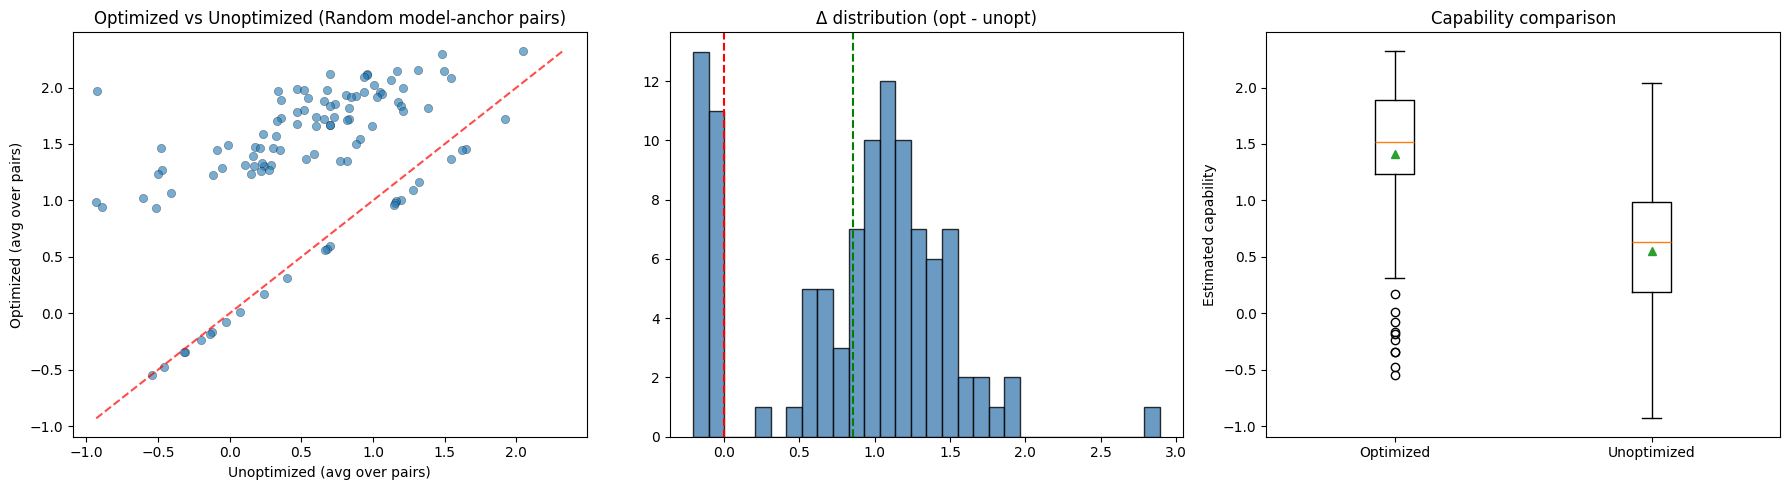


Anchor pairs used (first 10 of 20):
  - ('Meta-Llama-3-70B-Instruct', 'gpt-4-turbo-2024-04-09')
  - ('gpt-4-0613', 'gpt-5-nano-2025-08-07_medium')
  - ('Qwen-14B', 'grok-4-0709')
  - ('LLaMA-33B', 'claude-sonnet-4-20250514')
  - ('gemma-2-9b-it', 'mistral-large-2411')
  - ('gpt-4o-mini-2024-07-18', 'o1-2024-12-17_high')
  - ('Llama-3.1-405B', 'Qwen2.5-Coder-3B')
  - ('Llama-3.1-70B-Instruct', 'claude-3-sonnet-20240229')
  - ('Llama-2-13b', 'mpt-30b')
  - ('claude-instant-1.2', 'o4-mini-2025-04-16_medium')


In [ ]:
# View summary for random model-anchor pairs (run after the model-pairs cell)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel, wilcoxon, pearsonr, spearmanr
from pathlib import Path

# If variables exist, use them; else load from saved CSVs
if "opt_avg_pairs" in globals() and "unopt_avg_pairs" in globals():
    df_opt = opt_avg_pairs.rename("opt").to_frame()
    df_unpt = unopt_avg_pairs.rename("unopt").to_frame()
else:
    out_dir = Path("outputs/model_anchor_pairs")
    df_opt = (
        pd.read_csv(out_dir / "opt_avg_capabilities_random_model_anchors.csv")
        .set_index("model")
        .rename(columns={"opt_avg_modelAnchPairs": "opt"})
    )
    df_unpt = (
        pd.read_csv(out_dir / "unopt_avg_capabilities_random_model_anchors.csv")
        .set_index("model")
        .rename(columns={"unopt_avg_modelAnchPairs": "unopt"})
    )

comp = df_opt.join(df_unpt, how="inner").dropna()
comp["diff"] = comp["opt"] - comp["unopt"]
comp["ratio"] = comp["opt"] / comp["unopt"]

# Summary
t_stat, t_p = ttest_rel(comp["opt"], comp["unopt"])
w_stat, w_p = wilcoxon(comp["opt"], comp["unopt"])
r_p, p_p = pearsonr(comp["opt"], comp["unopt"])
r_s, p_s = spearmanr(comp["opt"], comp["unopt"])

summary_pairs_view = {
    "n_models_overlap": int(len(comp)),
    "mean_delta": float(comp["diff"].mean()),
    "median_delta": float(comp["diff"].median()),
    "std_delta": float(comp["diff"].std(ddof=0)),
    "t_stat": float(t_stat),
    "t_pvalue": float(t_p),
    "wilcoxon_stat": float(w_stat),
    "wilcoxon_pvalue": float(w_p),
    "pearson_r": float(r_p),
    "pearson_p": float(p_p),
    "spearman_rho": float(r_s),
    "spearman_p": float(p_s),
}
print(summary_pairs_view)

# Top/bottom models by delta
print("\nTop 10 Δ (opt - unopt):")
print(
    comp.sort_values("diff", ascending=False)
    .head(10)[["opt", "unopt", "diff"]]
    .to_string()
)

print("\nBottom 10 Δ (opt - unopt):")
print(
    comp.sort_values("diff", ascending=True)
    .head(10)[["opt", "unopt", "diff"]]
    .to_string()
)

# Quick plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].scatter(comp["unopt"], comp["opt"], alpha=0.6, edgecolors="k", linewidth=0.3)
mn = min(comp["opt"].min(), comp["unopt"].min())
mx = max(comp["opt"].max(), comp["unopt"].max())
axes[0].plot([mn, mx], [mn, mx], "r--", alpha=0.7)
axes[0].set_xlabel("Unoptimized (avg over pairs)")
axes[0].set_ylabel("Optimized (avg over pairs)")
axes[0].set_title("Optimized vs Unoptimized (Random model-anchor pairs)")

axes[1].hist(comp["diff"], bins=30, color="steelblue", edgecolor="k", alpha=0.8)
axes[1].axvline(0, color="red", linestyle="--")
axes[1].axvline(comp["diff"].mean(), color="green", linestyle="--")
axes[1].set_title("Δ distribution (opt - unopt)")

axes[2].boxplot(
    [comp["opt"], comp["unopt"]], labels=["Optimized", "Unoptimized"], showmeans=True
)
axes[2].set_ylabel("Estimated capability")
axes[2].set_title("Capability comparison")

plt.tight_layout()
plt.show()

# Optional: see which anchor pairs were used (if still in memory)
if "pairs" in globals():
    print(f"\nAnchor pairs used (first 10 of {len(pairs)}):")
    for p in pairs[:10]:
        print("  -", p)

# Random Partition Comparison (Robustness Check)


In [ ]:
# ── Check if anchor models are in the dataset ──────────────────────────────

anchor_model1 = "claude-3-opus-20240229"
anchor_model2 = "claude-opus-4-20250514"

print("Checking anchor models in dataset:")
print(f"  {anchor_model1} in data: {anchor_model1 in scores_df['model'].values}")
print(f"  {anchor_model2} in data: {anchor_model2 in scores_df['model'].values}")

# Check in optimized and unoptimized subsets
print(f"\nIn optimized subset:")
print(f"  {anchor_model1}: {anchor_model1 in opt_df['model'].values}")
print(f"  {anchor_model2}: {anchor_model2 in opt_df['model'].values}")

print(f"\nIn unoptimized subset:")
print(f"  {anchor_model1}: {anchor_model1 in unopt_df['model'].values}")
print(f"  {anchor_model2}: {anchor_model2 in unopt_df['model'].values}")

Checking anchor models in dataset:
  claude-3-opus-20240229 in data: True
  claude-opus-4-20250514 in data: True

In optimized subset:
  claude-3-opus-20240229: True
  claude-opus-4-20250514: True

In unoptimized subset:
  claude-3-opus-20240229: True
  claude-opus-4-20250514: True


In [ ]:
# ── Random Partition Analysis ──────────────────────────────────────────────

# Perform random partitions to compare with optimized vs unoptimized split
n_random_partitions = 1000  # Number of random splits to try
random_seed = 42

# Define anchor models (these will be in both partitions)
anchor_model1 = "claude-3-opus-20240229"
anchor_model2 = "claude-opus-4-20250514"

print("=" * 80)
print("RANDOM PARTITION ROBUSTNESS CHECK")
print("=" * 80)
print(
    f"\nComparing optimized vs unoptimized split against {n_random_partitions} random partitions"
)
print(
    f"This helps determine if the observed differences are meaningful or due to sampling."
)
print(f"\nNote: Anchor models ({anchor_model1}, {anchor_model2})")
print(f"      will be included in BOTH partitions to ensure consistent anchoring.\n")

# Store results from random partitions
random_results = []

# Get the actual optimized vs unoptimized comparison stats (from earlier cell)
actual_mean_diff = comparison_df["capability_diff"].mean()
actual_median_diff = comparison_df["capability_diff"].median()
actual_std_diff = comparison_df["capability_diff"].std()
actual_pvalue = t_pvalue
actual_n_overlap = len(comparison_df)

# Get partition sizes to match
n_opt = len(opt_df)
n_unopt = len(unopt_df)
total_n = len(scores_df)

print(
    f"Actual partition sizes: Optimized={n_opt}, Unoptimized={n_unopt}, Total={total_n}"
)
print(f"Actual overlap models: {actual_n_overlap}")

# Run random partitions
np.random.seed(random_seed)
for i in range(n_random_partitions):
    # Separate anchor models from the rest of the data to ensure they're in both partitions
    anchor_models = [anchor_model1, anchor_model2]
    anchor_data = scores_df[scores_df["model"].isin(anchor_models)]
    non_anchor_data = scores_df[~scores_df["model"].isin(anchor_models)]

    # # Randomly partition only the non-anchor data
    # random_mask = np.random.rand(len(non_anchor_data)) < (n_opt / total_n)
    # random_part1_noanchor = non_anchor_data[random_mask]
    # random_part2_noanchor = non_anchor_data[~random_mask]

    # Randomly partition by BENCHMARK with a fixed benchmark ratio
    # Compute target number of unique benchmarks for partition 1
    total_unique_bench = non_anchor_data["benchmark_id"].nunique()
    # Ratio based on unique benchmarks seen in real optimized vs total
    bench_ratio = (
        scores_df[scores_df["optimized"]]["benchmark_id"].nunique()
        / scores_df["benchmark_id"].nunique()
    )
    k_bench = max(
        1, min(total_unique_bench - 1, int(round(bench_ratio * total_unique_bench)))
    )

    # Sample benchmarks and split all rows of those benchmarks
    chosen_benchmarks = np.random.choice(
        non_anchor_data["benchmark_id"].unique(), size=k_bench, replace=False
    )
    random_part1_noanchor = non_anchor_data[
        non_anchor_data["benchmark_id"].isin(chosen_benchmarks)
    ]
    random_part2_noanchor = non_anchor_data[
        ~non_anchor_data["benchmark_id"].isin(chosen_benchmarks)
    ]

    # Add anchor models to BOTH partitions to ensure consistent anchoring
    random_part1 = pd.concat([random_part1_noanchor, anchor_data], ignore_index=True)
    random_part2 = pd.concat([random_part2_noanchor, anchor_data], ignore_index=True)

    # Fit both partitions
    try:
        # Use different seeds per partition to ensure varied inits
        _, df_cm_rand1, _ = fit_statistical_model(
            random_part1,
            anchor_mode="model",
            anchor_benchmark="Winogrande",
            anchor_difficulty=0,
            anchor_slope=1,
            anchor_model1="claude-3-opus-20240229",
            anchor_model1_capability=1.510032,
            anchor_model2="claude-opus-4-20250514",
            anchor_model2_capability=2.015441,
            random_state=42 + i * 2,
        )

        _, df_cm_rand2, _ = fit_statistical_model(
            random_part2,
            anchor_mode="model",
            anchor_benchmark="Winogrande",
            anchor_difficulty=0,
            anchor_slope=1,
            anchor_model1="claude-3-opus-20240229",
            anchor_model1_capability=1.510032,
            anchor_model2="claude-opus-4-20250514",
            anchor_model2_capability=2.015441,
            random_state=43 + i * 2,
        )

        # Compare overlapping models
        comparison_rand = df_cm_rand1[["model", "estimated_capability"]].merge(
            df_cm_rand2[["model", "estimated_capability"]],
            on="model",
            suffixes=("_1", "_2"),
            how="inner",
        )

        if len(comparison_rand) > 10:  # Only analyze if enough overlap
            comparison_rand["diff"] = (
                comparison_rand["estimated_capability_1"]
                - comparison_rand["estimated_capability_2"]
            )

            # Calculate stats
            mean_diff = comparison_rand["diff"].mean()
            median_diff = comparison_rand["diff"].median()
            std_diff = comparison_rand["diff"].std()

            # Paired t-test
            t_stat_rand, p_value_rand = ttest_rel(
                comparison_rand["estimated_capability_1"],
                comparison_rand["estimated_capability_2"],
            )

            random_results.append(
                {
                    "partition": i + 1,
                    "n_overlap": len(comparison_rand),
                    "mean_diff": mean_diff,
                    "median_diff": median_diff,
                    "std_diff": std_diff,
                    "abs_mean_diff": abs(mean_diff),
                    "p_value": p_value_rand,
                }
            )

    except Exception as e:
        print(f"  Warning: Partition {i+1} failed - {str(e)[:50]}")
        continue

# Convert to DataFrame
random_df = pd.DataFrame(random_results)

# Summary statistics
print(f"\n" + "-" * 80)
print("RANDOM PARTITION STATISTICS (across {len(random_df)} successful partitions):")
print("-" * 80)
print(f"Mean difference:")
print(
    f"  Random partitions: {random_df['mean_diff'].mean():.4f} ± {random_df['mean_diff'].std():.4f}"
)
print(f"  Actual (opt vs unopt): {actual_mean_diff:.4f}")

print(f"\nAbsolute mean difference:")
print(
    f"  Random partitions: {random_df['abs_mean_diff'].mean():.4f} ± {random_df['abs_mean_diff'].std():.4f}"
)
print(f"  Actual (opt vs unopt): {abs(actual_mean_diff):.4f}")

print(f"\nStd deviation of differences:")
print(
    f"  Random partitions: {random_df['std_diff'].mean():.4f} ± {random_df['std_diff'].std():.4f}"
)
print(f"  Actual (opt vs unopt): {actual_std_diff:.4f}")

print(f"\nP-values (paired t-test):")
print(
    f"  Random partitions: {random_df['p_value'].mean():.4f} ± {random_df['p_value'].std():.4f}"
)
print(f"  Actual (opt vs unopt): {actual_pvalue:.4f}")

# Check if actual is an outlier compared to random
actual_abs_diff_percentile = (
    random_df["abs_mean_diff"] < abs(actual_mean_diff)
).mean() * 100
print(f"\n" + "-" * 80)
print("INTERPRETATION:")
print("-" * 80)
print(
    f"The actual absolute difference ({abs(actual_mean_diff):.4f}) is at the {actual_abs_diff_percentile:.1f}th percentile"
)
print(f"of the random partition distribution.")

if actual_abs_diff_percentile > 90:
    print(
        f"✓ The optimized vs unoptimized split shows LARGER differences than {actual_abs_diff_percentile:.0f}% of random splits."
    )
    print(
        f"  → This suggests the difference is MEANINGFUL, not just due to random sampling."
    )
elif actual_abs_diff_percentile > 75:
    print(
        f"⚠ The optimized vs unoptimized split shows larger differences than {actual_abs_diff_percentile:.0f}% of random splits."
    )
    print(f"  → This suggests some meaningful difference, but not dramatic.")
else:
    print(f"✗ The optimized vs unoptimized split is similar to random partitions.")
    print(
        f"  → The observed difference may be due to sampling, not systematic effects."
    )

print("=" * 80)

RANDOM PARTITION ROBUSTNESS CHECK

Comparing optimized vs unoptimized split against 1000 random partitions
This helps determine if the observed differences are meaningful or due to sampling.

Note: Anchor models (claude-3-opus-20240229, claude-opus-4-20250514)
      will be included in BOTH partitions to ensure consistent anchoring.

Actual partition sizes: Optimized=1023, Unoptimized=283, Total=1306
Actual overlap models: 82
`ftol` termination condition is satisfied.
Function evaluations 44, initial cost 3.6419e+01, final cost 1.9114e+00, first-order optimality 1.89e-05.
`ftol` termination condition is satisfied.
Function evaluations 54, initial cost 1.8309e+01, final cost 1.2479e+00, first-order optimality 1.58e-04.
`ftol` termination condition is satisfied.
Function evaluations 26, initial cost 3.7242e+01, final cost 2.0904e+00, first-order optimality 1.18e-04.
`ftol` termination condition is satisfied.
Function evaluations 41, initial cost 1.5051e+01, final cost 7.1759e-01, first-o

KeyboardInterrupt: 

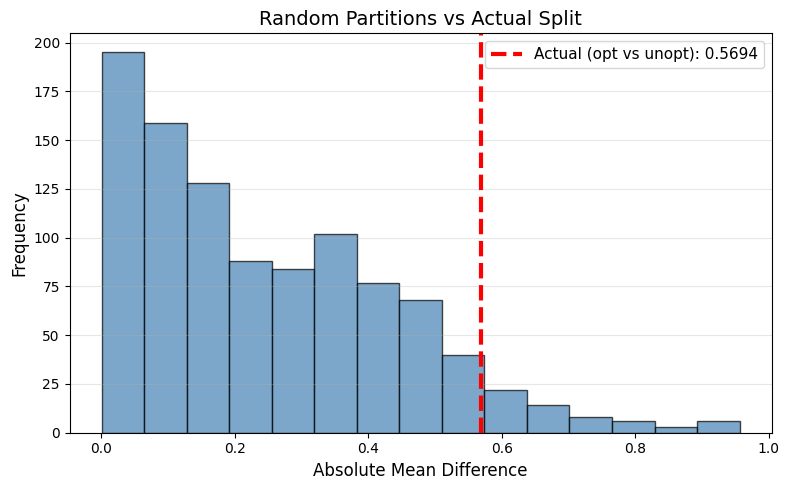


RANDOM PARTITION RESULTS TABLE:
--------------------------------------------------------------------------------
 partition  n_overlap  mean_diff  median_diff  std_diff  abs_mean_diff      p_value
         1        144  -0.229098    -0.316420  0.444735       0.229098 6.267332e-09
         2        141  -0.010571     0.053582  0.420070       0.010571 7.655279e-01
         3        144   0.058480    -0.050821  0.505035       0.058480 1.668324e-01
         4        118   0.493926     0.417911  0.621067       0.493926 3.392893e-14
         5        144   0.096235     0.089760  0.480137       0.096235 1.744268e-02
         6        133   0.192356     0.113023  0.310996       0.192356 5.825944e-11
         7        142  -0.040861    -0.013839  0.402623       0.040861 2.285490e-01
         8        145   0.020770    -0.002460  0.289170       0.020770 3.885351e-01
         9        143  -0.179235    -0.088914  0.334424       0.179235 2.019803e-09
        10        144  -0.071984    -0.042404 

In [ ]:
# ── Visualize Random Partition Comparison ──────────────────────────────────

# Single plot: Distribution of absolute mean differences
fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(
    random_df["abs_mean_diff"], bins=15, alpha=0.7, color="steelblue", edgecolor="black"
)
ax.axvline(
    abs(actual_mean_diff),
    color="red",
    linestyle="--",
    linewidth=3,
    label=f"Actual (opt vs unopt): {abs(actual_mean_diff):.4f}",
)
ax.set_xlabel("Absolute Mean Difference", fontsize=12)
ax.set_ylabel("Frequency", fontsize=12)
ax.set_title("Random Partitions vs Actual Split", fontsize=14)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis="y")

plt.tight_layout()
plt.savefig(
    "outputs/notebooks/random_partition_comparison.pdf", dpi=300, bbox_inches="tight"
)
plt.show()

# Print summary table
print("\nRANDOM PARTITION RESULTS TABLE:")
print("-" * 80)
print(random_df.to_string(index=False))

In [ ]:
# ── Percentile & rank: mean(larger-benchmark-set) − mean(smaller-benchmark-set) ──

# Reuse the same logic for which side is larger in random partitions
anchor_models = [anchor_model1, anchor_model2]
non_anchor_data = scores_df[~scores_df["model"].isin(anchor_models)]

total_unique_bench = non_anchor_data["benchmark_id"].nunique()
bench_ratio = (
    scores_df[scores_df["optimized"]]["benchmark_id"].nunique()
    / scores_df["benchmark_id"].nunique()
)
k_bench = max(
    1, min(total_unique_bench - 1, int(round(bench_ratio * total_unique_bench)))
)
larger_is_part2 = (total_unique_bench - k_bench) >= k_bench

# Convert stored mean_diff (part1 − part2) to larger − smaller (SIGNED)
if larger_is_part2:
    larger_minus_smaller_signed = -random_df["mean_diff"]
else:
    larger_minus_smaller_signed = random_df["mean_diff"]

# Actual signed larger − smaller based on which real split has more unique benchmarks
opt_unique_bench = opt_df["benchmark_id"].nunique()
unopt_unique_bench = unopt_df["benchmark_id"].nunique()
actual_signed_larger_minus_smaller = (
    actual_mean_diff if opt_unique_bench >= unopt_unique_bench else -actual_mean_diff
)

# Percentile and rank of the actual value within the random signed distribution
sorted_vals = np.sort(larger_minus_smaller_signed.values)
rnk = int((sorted_vals < actual_signed_larger_minus_smaller).sum()) + 1  # 1-based rank
percentile_signed = (
    larger_minus_smaller_signed < actual_signed_larger_minus_smaller
).mean() * 100

print("SIGNED LARGER−SMALLER MEAN DIFF: Percentile and Rank")
print("-" * 80)
print(
    f"Random (signed larger−smaller): mean={larger_minus_smaller_signed.mean():.4f}, std={larger_minus_smaller_signed.std():.4f}"
)
print(f"Actual signed larger−smaller: {actual_signed_larger_minus_smaller:.4f}")
print(f"Percentile (strictly less than): {percentile_signed:.1f}th")
print(f"Rank (1=smallest): {rnk} of {len(sorted_vals)}")

SIGNED LARGER−SMALLER MEAN DIFF: Percentile and Rank
--------------------------------------------------------------------------------
Random (signed larger−smaller): mean=0.1435, std=0.2799
Actual signed larger−smaller: 0.5694
Percentile (strictly less than): 94.3th
Rank (1=smallest): 944 of 1000


# Growth Rate Analysis: Models in Both Datasets Only


In [ ]:
# ── Filter to models in both datasets ──────────────────────────────────────

# Get list of models that appear in both datasets
models_in_both = comparison_df["model"].unique()

print("=" * 80)
print("GROWTH RATE ANALYSIS: MODELS IN BOTH DATASETS ONLY")
print("=" * 80)
print(
    f"\nAnalyzing growth rates for {len(models_in_both)} models that appear in both datasets"
)
print(f"This provides an apples-to-apples comparison.\n")

# Filter the capability dataframes to only include these models
df_cm_opt_both = df_cm_opt[df_cm_opt["model"].isin(models_in_both)].copy()
df_cm_unopt_both = df_cm_unopt[df_cm_unopt["model"].isin(models_in_both)].copy()

print(f"Optimized dataset: {len(df_cm_opt_both)} model entries")
print(f"Unoptimized dataset: {len(df_cm_unopt_both)} model entries")

GROWTH RATE ANALYSIS: MODELS IN BOTH DATASETS ONLY

Analyzing growth rates for 74 models that appear in both datasets
This provides an apples-to-apples comparison.

Optimized dataset: 74 model entries
Unoptimized dataset: 74 model entries


In [ ]:
# ── Bootstrap growth rate: Optimized (models in both) ──────────────────────

# Ensure date is properly formatted
df_cm_opt_both["date_obj"] = pd.to_datetime(df_cm_opt_both["date_obj"])
df_cm_opt_both = (
    df_cm_opt_both.dropna(subset=["date_obj", "estimated_capability"])
    .sort_values("date_obj")
    .reset_index(drop=True)
)

cap_dates_num_opt = mdates.date2num(df_cm_opt_both["date_obj"])
cap_values_opt = df_cm_opt_both["estimated_capability"]

# Bootstrap
n_boot = 10000
rng = np.random.default_rng(0)

mask = ~(np.isnan(cap_dates_num_opt) | np.isnan(cap_values_opt))
x_full = cap_dates_num_opt[mask]
y_full = cap_values_opt[mask].to_numpy()

boot_slopes_year_opt = np.empty(n_boot)
for i in range(n_boot):
    idx = rng.choice(len(x_full), len(x_full), replace=True)
    slope_day, _ = np.polyfit(x_full[idx], y_full[idx], 1)
    boot_slopes_year_opt[i] = slope_day * 365.25

mean_rate_opt = boot_slopes_year_opt.mean()
ci_lower_opt, ci_upper_opt = np.percentile(boot_slopes_year_opt, [2.5, 97.5])

print("\n" + "-" * 80)
print("OPTIMIZED BENCHMARKS (models in both datasets)")
print("-" * 80)
print(f"Bootstrap mean rate: {mean_rate_opt:.4f} capability units/year")
print(f"95% confidence interval: [{ci_lower_opt:.4f}, {ci_upper_opt:.4f}]")
print(f"Number of models: {len(df_cm_opt_both)}")


--------------------------------------------------------------------------------
OPTIMIZED BENCHMARKS (models in both datasets)
--------------------------------------------------------------------------------
Bootstrap mean rate: 0.6000 capability units/year
95% confidence interval: [0.5034, 0.7107]
Number of models: 74


In [ ]:
# ── Bootstrap growth rate: Unoptimized (models in both) ────────────────────

# Ensure date is properly formatted
df_cm_unopt_both["date_obj"] = pd.to_datetime(df_cm_unopt_both["date_obj"])
df_cm_unopt_both = (
    df_cm_unopt_both.dropna(subset=["date_obj", "estimated_capability"])
    .sort_values("date_obj")
    .reset_index(drop=True)
)

cap_dates_num_unopt = mdates.date2num(df_cm_unopt_both["date_obj"])
cap_values_unopt = df_cm_unopt_both["estimated_capability"]

# Bootstrap
mask = ~(np.isnan(cap_dates_num_unopt) | np.isnan(cap_values_unopt))
x_full = cap_dates_num_unopt[mask]
y_full = cap_values_unopt[mask].to_numpy()

boot_slopes_year_unopt = np.empty(n_boot)
rng = np.random.default_rng(0)  # Same seed for reproducibility
for i in range(n_boot):
    idx = rng.choice(len(x_full), len(x_full), replace=True)
    slope_day, _ = np.polyfit(x_full[idx], y_full[idx], 1)
    boot_slopes_year_unopt[i] = slope_day * 365.25

mean_rate_unopt = boot_slopes_year_unopt.mean()
ci_lower_unopt, ci_upper_unopt = np.percentile(boot_slopes_year_unopt, [2.5, 97.5])

print("\n" + "-" * 80)
print("UNOPTIMIZED BENCHMARKS (models in both datasets)")
print("-" * 80)
print(f"Bootstrap mean rate: {mean_rate_unopt:.4f} capability units/year")
print(f"95% confidence interval: [{ci_lower_unopt:.4f}, {ci_upper_unopt:.4f}]")
print(f"Number of models: {len(df_cm_unopt_both)}")


--------------------------------------------------------------------------------
UNOPTIMIZED BENCHMARKS (models in both datasets)
--------------------------------------------------------------------------------
Bootstrap mean rate: 0.8045 capability units/year
95% confidence interval: [0.5430, 1.0676]
Number of models: 74



COMPARISON: OPTIMIZED vs UNOPTIMIZED (Same Models)

Bootstrap Growth Rates (capability units/year):
  Optimized:   0.6000 [0.5034, 0.7107]
  Unoptimized: 0.8045 [0.5430, 1.0676]
  Difference:  -0.2046

Confidence intervals overlap: True
  → Growth rates are NOT significantly different (at 95% confidence)


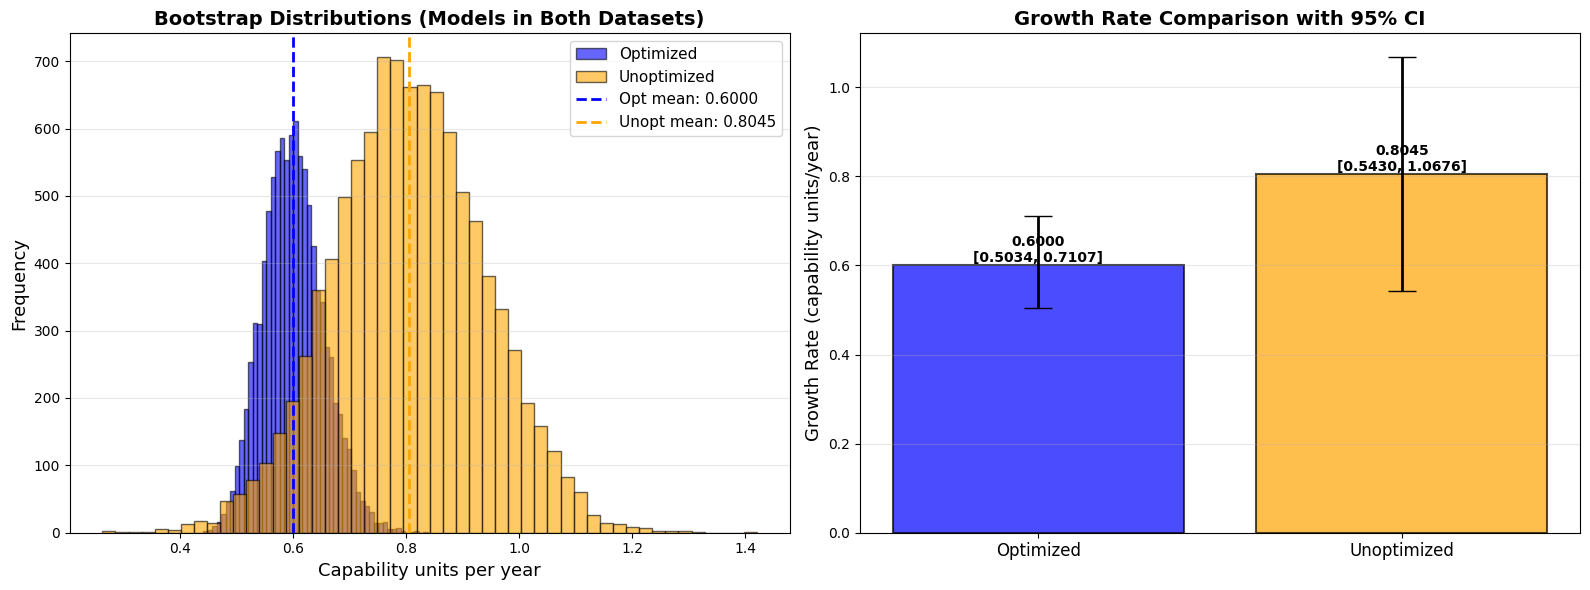

In [ ]:
# ── Comparison and visualization ───────────────────────────────────────────

print("\n" + "=" * 80)
print("COMPARISON: OPTIMIZED vs UNOPTIMIZED (Same Models)")
print("=" * 80)

print("\nBootstrap Growth Rates (capability units/year):")
print(f"  Optimized:   {mean_rate_opt:.4f} [{ci_lower_opt:.4f}, {ci_upper_opt:.4f}]")
print(
    f"  Unoptimized: {mean_rate_unopt:.4f} [{ci_lower_unopt:.4f}, {ci_upper_unopt:.4f}]"
)
print(f"  Difference:  {mean_rate_opt - mean_rate_unopt:.4f}")

# Check if confidence intervals overlap
ci_overlap = not (ci_upper_opt < ci_lower_unopt or ci_upper_unopt < ci_lower_opt)
print(f"\nConfidence intervals overlap: {ci_overlap}")
if not ci_overlap:
    print("  → Growth rates are SIGNIFICANTLY DIFFERENT")
else:
    print("  → Growth rates are NOT significantly different (at 95% confidence)")

# Visualize the comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Bootstrap distributions
ax1 = axes[0]
ax1.hist(
    boot_slopes_year_opt,
    bins=50,
    alpha=0.6,
    color="blue",
    label="Optimized",
    edgecolor="black",
)
ax1.hist(
    boot_slopes_year_unopt,
    bins=50,
    alpha=0.6,
    color="orange",
    label="Unoptimized",
    edgecolor="black",
)
ax1.axvline(
    mean_rate_opt,
    color="blue",
    linestyle="--",
    linewidth=2,
    label=f"Opt mean: {mean_rate_opt:.4f}",
)
ax1.axvline(
    mean_rate_unopt,
    color="orange",
    linestyle="--",
    linewidth=2,
    label=f"Unopt mean: {mean_rate_unopt:.4f}",
)
ax1.set_xlabel("Capability units per year", fontsize=13)
ax1.set_ylabel("Frequency", fontsize=13)
ax1.set_title(
    "Bootstrap Distributions (Models in Both Datasets)", fontsize=14, fontweight="bold"
)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3, axis="y")

# Plot 2: Comparison with error bars
ax2 = axes[1]
categories = ["Optimized", "Unoptimized"]
means = [mean_rate_opt, mean_rate_unopt]
errors_lower = [mean_rate_opt - ci_lower_opt, mean_rate_unopt - ci_lower_unopt]
errors_upper = [ci_upper_opt - mean_rate_opt, ci_upper_unopt - mean_rate_unopt]

x_pos = np.arange(len(categories))
bars = ax2.bar(
    x_pos,
    means,
    yerr=[errors_lower, errors_upper],
    capsize=10,
    alpha=0.7,
    color=["blue", "orange"],
    edgecolor="black",
    linewidth=1.5,
    error_kw={"linewidth": 2},
)

ax2.set_ylabel("Growth Rate (capability units/year)", fontsize=13)
ax2.set_title("Growth Rate Comparison with 95% CI", fontsize=14, fontweight="bold")
ax2.set_xticks(x_pos)
ax2.set_xticklabels(categories, fontsize=12)
ax2.grid(True, alpha=0.3, axis="y")

# Add value labels on bars
for i, (bar, mean, lower, upper) in enumerate(
    zip(bars, means, errors_lower, errors_upper)
):
    height = bar.get_height()
    ax2.text(
        bar.get_x() + bar.get_width() / 2.0,
        height,
        f"{mean:.4f}\n[{mean-lower:.4f}, {mean+upper:.4f}]",
        ha="center",
        va="bottom",
        fontsize=10,
        fontweight="bold",
    )

plt.tight_layout()
plt.savefig("growth_rate_comparison_models_in_both.pdf", dpi=300, bbox_inches="tight")
plt.show()

print("\n" + "=" * 80)

# Benchmark anchor approach

In [ ]:
# Reference fit anchored on Winogrande to cache per-benchmark difficulty (D) and slope (α)
import numpy as np
import pandas as pd
from scipy.optimize import least_squares

from data_loader import scores_df
from fit import fit_statistical_model

ref_df, ref_cap, ref_bench = fit_statistical_model(
    scores_df,
    anchor_mode="benchmark",
    anchor_benchmark="Winogrande",
    anchor_difficulty=0.0,
    anchor_slope=1.0,
)

REF_D_BY_NAME = dict(
    zip(ref_bench["benchmark_name"], ref_bench["estimated_difficulty"])
)
REF_ALPHA_BY_NAME = dict(zip(ref_bench["benchmark_name"], ref_bench["estimated_slope"]))

print(f"Reference fit cached: {len(REF_D_BY_NAME)} benchmarks.")

`ftol` termination condition is satisfied.
Function evaluations 32, initial cost 4.5427e+01, final cost 3.4998e+00, first-order optimality 8.87e-04.
Reference fit cached: 39 benchmarks.


In [ ]:
def fit_subset_with_benchmark_anchor_ref_init(
    df_subset: pd.DataFrame,
    anchor_benchmark: str,
    slope_init: float = 1.0,
    regularization_strength: float = 0.1,
    random_state: int | None = 42,
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Fit on a subset using a benchmark anchor; initialize D and α from the reference fit
    for all benchmarks present; fix anchor α to its reference; shift C/D so that
    anchor D equals its reference D.
    Returns (model_capabilities_df, benchmark_params_df).
    """
    df = df_subset.copy().reset_index(drop=True)
    if df.empty:
        raise ValueError("df_subset is empty")

    valid_model_ids = df["model_id"].unique()
    benchmark_ids = df["benchmark_id"].unique()
    model_id_to_idx = {m: i for i, m in enumerate(valid_model_ids)}
    bench_id_to_idx = {b: i for i, b in enumerate(benchmark_ids)}

    num_models = len(valid_model_ids)
    num_benchmarks = len(benchmark_ids)

    model_idx_data = np.array([model_id_to_idx[m] for m in df["model_id"]])
    bench_idx_data = np.array([bench_id_to_idx[b] for b in df["benchmark_id"]])
    observed_scores = df["performance"].to_numpy()

    try:
        anchor_bench_id = df.loc[
            df["benchmark"] == anchor_benchmark, "benchmark_id"
        ].iloc[0]
    except IndexError as e:
        raise ValueError(f"Anchor '{anchor_benchmark}' not in subset") from e
    anchor_idx = bench_id_to_idx[anchor_bench_id]

    def logistic(x: np.ndarray) -> np.ndarray:
        return 1.0 / (1.0 + np.exp(-np.clip(x, -500, 500)))

    rng = np.random.default_rng(random_state)
    initial_C = rng.normal(0.0, 0.1, size=num_models)

    bench_id_to_name = (
        df.drop_duplicates("benchmark_id")
        .set_index("benchmark_id")["benchmark"]
        .to_dict()
    )
    initial_D = np.zeros(num_benchmarks)
    initial_alpha_full = np.zeros(num_benchmarks)
    for b_id, idx in bench_id_to_idx.items():
        bname = bench_id_to_name[b_id]
        initial_D[idx] = float(REF_D_BY_NAME.get(bname, 0.0))
        initial_alpha_full[idx] = float(REF_ALPHA_BY_NAME.get(bname, slope_init))

    anchor_slope_ref = float(REF_ALPHA_BY_NAME.get(anchor_benchmark, 1.0))
    initial_alpha_free = np.delete(initial_alpha_full, anchor_idx)

    def split_params(theta: np.ndarray):
        C = theta[:num_models]
        D = theta[num_models : num_models + num_benchmarks]
        alpha_free = theta[num_models + num_benchmarks :]
        alpha = np.insert(alpha_free, anchor_idx, anchor_slope_ref)
        return C, D, alpha

    def residuals(theta: np.ndarray) -> np.ndarray:
        C, D, alpha = split_params(theta)
        preds = logistic(
            alpha[bench_idx_data] * (C[model_idx_data] - D[bench_idx_data])
        )
        resids = preds - observed_scores
        if regularization_strength > 0:
            reg = (
                regularization_strength
                * (
                    np.sum(C**2)
                    + np.sum(D**2)
                    + np.sum(alpha[np.arange(len(alpha)) != anchor_idx] ** 2)
                )
                / (num_models + num_benchmarks + num_benchmarks - 1)
            )
            reg_penalty = np.sqrt(reg) if reg > 0 else 0.0
            return np.append(resids, reg_penalty)
        return resids

    initial_theta = np.concatenate([initial_C, initial_D, initial_alpha_free])

    lower_bounds = np.concatenate(
        [
            np.full(num_models, -10.0),
            np.full(num_benchmarks, -10.0),
            np.full(num_benchmarks - 1, 0.1),
        ]
    )
    upper_bounds = np.concatenate(
        [
            np.full(num_models, 10.0),
            np.full(num_benchmarks, 10.0),
            np.full(num_benchmarks - 1, 10.0),
        ]
    )

    result = least_squares(
        residuals,
        initial_theta,
        bounds=(lower_bounds, upper_bounds),
        method="trf",
        verbose=0,
    )

    theta_hat = result.x
    C_hat = theta_hat[:num_models]
    D_hat = theta_hat[num_models : num_models + num_benchmarks]
    alpha_free_hat = theta_hat[num_models + num_benchmarks :]
    alpha_hat = np.insert(alpha_free_hat, anchor_idx, anchor_slope_ref)

    anchor_D_ref = float(REF_D_BY_NAME.get(anchor_benchmark, 0.0))
    shift = D_hat[anchor_idx] - anchor_D_ref
    C_hat = C_hat - shift
    D_hat = D_hat - shift

    id_to_model = (
        df.drop_duplicates("model_id").set_index("model_id")["model"].to_dict()
    )
    model_capabilities_df = (
        pd.DataFrame({"model_id": valid_model_ids, "estimated_capability": C_hat})
        .assign(model=lambda d: d["model_id"].map(id_to_model))
        .sort_values("estimated_capability", ascending=False)
        .reset_index(drop=True)
    )

    bench_params_df = (
        pd.DataFrame(
            {
                "benchmark_id": benchmark_ids,
                "estimated_difficulty": D_hat,
                "estimated_slope": alpha_hat,
            }
        )
        .assign(benchmark_name=lambda d: d["benchmark_id"].map(bench_id_to_name))
        .sort_values("estimated_difficulty")
        .reset_index(drop=True)
    )

    return model_capabilities_df, bench_params_df


def ensure_anchor_present(part_df: pd.DataFrame, anchor_name: str) -> pd.DataFrame:
    """Include the anchor benchmark rows if missing from the partition."""
    if anchor_name in part_df["benchmark"].unique():
        return part_df
    return pd.concat(
        [part_df, scores_df[scores_df["benchmark"] == anchor_name]], ignore_index=True
    )

In [ ]:
# Partitions
opt_df = scores_df[scores_df["optimized"]].copy()
unopt_df = scores_df[~scores_df["optimized"]].copy()

# Top-10 by coverage within each partition
cov_opt = opt_df.groupby("benchmark")["model"].nunique().sort_values(ascending=False)
cov_unopt = (
    unopt_df.groupby("benchmark")["model"].nunique().sort_values(ascending=False)
)
opt_anchors = cov_opt.head(10).index.tolist()
unopt_anchors = cov_unopt.head(10).index.tolist()
anchors20 = opt_anchors + unopt_anchors

# Run fits for each anchor on both partitions (anchor enforced if missing)
opt_caps_by_anchor = []
unopt_caps_by_anchor = []
for anc in anchors20:
    mcap_opt, _ = fit_subset_with_benchmark_anchor_ref_init(
        ensure_anchor_present(opt_df, anc), anc
    )
    mcap_unopt, _ = fit_subset_with_benchmark_anchor_ref_init(
        ensure_anchor_present(unopt_df, anc), anc
    )
    opt_caps_by_anchor.append(mcap_opt.set_index("model")["estimated_capability"])
    unopt_caps_by_anchor.append(mcap_unopt.set_index("model")["estimated_capability"])

# Average across anchors in each partition
opt_avg20 = pd.concat(opt_caps_by_anchor, axis=1).mean(axis=1)
unopt_avg20 = pd.concat(unopt_caps_by_anchor, axis=1).mean(axis=1)

# Difference over overlapping models
common20 = opt_avg20.index.intersection(unopt_avg20.index)
delta20 = opt_avg20.loc[common20] - unopt_avg20.loc[common20]

print(
    {
        "approach": 1,
        "n_opt_anchors": len(opt_anchors),
        "n_unopt_anchors": len(unopt_anchors),
        "n_models_overlap": int(len(common20)),
        "delta_mean": float(delta20.mean()),
        "delta_median": float(delta20.median()),
        "delta_std": float(delta20.std(ddof=0)),
    }
)

{'approach': 1, 'n_opt_anchors': 10, 'n_unopt_anchors': 10, 'n_models_overlap': 170, 'delta_mean': -0.024928387387021998, 'delta_median': -0.016756465682330246, 'delta_std': 0.22864880752918562}


In [ ]:
# Count optimized vs unoptimized benchmarks (total ~31)
bench_meta = scores_df.drop_duplicates("benchmark")[["benchmark", "optimized"]]
opt_bench_set = set(bench_meta[bench_meta["optimized"] == True]["benchmark"])
num_opt_total = int(len(opt_bench_set))
num_unopt_total = int(len(bench_meta) - num_opt_total)
num_total = num_opt_total + num_unopt_total

# Per spec: weights = 11/31 for optimized-anchors and 20/31 for unoptimized-anchors (generalized)
w_optAnch = num_unopt_total / num_total
w_unoptAnch = num_opt_total / num_total

all_benchmarks = bench_meta["benchmark"].tolist()

opt_caps_optAnch = []
opt_caps_unoptAnch = []
unopt_caps_optAnch = []
unopt_caps_unoptAnch = []

for anc in all_benchmarks:
    is_opt_anchor = anc in opt_bench_set

    # Optimized partition
    mcap_opt, _ = fit_subset_with_benchmark_anchor_ref_init(
        ensure_anchor_present(opt_df, anc), anc
    )
    s_opt = mcap_opt.set_index("model")["estimated_capability"]
    (opt_caps_optAnch if is_opt_anchor else opt_caps_unoptAnch).append(s_opt)

    # Unoptimized partition
    mcap_unopt, _ = fit_subset_with_benchmark_anchor_ref_init(
        ensure_anchor_present(unopt_df, anc), anc
    )
    s_unopt = mcap_unopt.set_index("model")["estimated_capability"]
    (unopt_caps_optAnch if is_opt_anchor else unopt_caps_unoptAnch).append(s_unopt)


def _simple_avg(series_list: list[pd.Series]) -> pd.Series:
    if not series_list:
        return pd.Series(dtype=float)
    return pd.concat(series_list, axis=1).mean(axis=1)


# Averages within anchor categories
opt_avg_over_optAnch = _simple_avg(opt_caps_optAnch)
opt_avg_over_unoptAnch = _simple_avg(opt_caps_unoptAnch)
unopt_avg_over_optAnch = _simple_avg(unopt_caps_optAnch)
unopt_avg_over_unoptAnch = _simple_avg(unopt_caps_unoptAnch)

# Weighted averages per set
opt_weighted = (opt_avg_over_optAnch * w_optAnch).add(
    opt_avg_over_unoptAnch * w_unoptAnch, fill_value=0
)
unopt_weighted = (unopt_avg_over_optAnch * w_optAnch).add(
    unopt_avg_over_unoptAnch * w_unoptAnch, fill_value=0
)

# Difference over overlapping models
common_w = opt_weighted.index.intersection(unopt_weighted.index)
delta_w = opt_weighted.loc[common_w] - unopt_weighted.loc[common_w]

print(
    {
        "approach": 2,
        "n_benchmarks_total": num_total,
        "n_opt_benchmarks": num_opt_total,
        "n_unopt_benchmarks": num_unopt_total,
        "n_models_overlap": int(len(common_w)),
        "delta_mean_weighted": float(delta_w.mean()),
        "delta_median_weighted": float(delta_w.median()),
        "delta_std_weighted": float(delta_w.std(ddof=0)),
    }
)

{'approach': 2, 'n_benchmarks_total': 39, 'n_opt_benchmarks': 25, 'n_unopt_benchmarks': 14, 'n_models_overlap': 170, 'delta_mean_weighted': 0.36427956282586926, 'delta_median_weighted': 0.2527477762606498, 'delta_std_weighted': 0.42298800136375425}


{'approach': 1, 'n_models_overlap': 170, 'mean_diff': -0.024928387387021994, 'median_diff': -0.016756465682330246, 'std_diff': 0.22864880752918565, 't_pvalue': 0.158229698344156, 'wilcoxon_pvalue': 0.04805505338722498, 'pearson_r': 0.9490881421284783, 'spearman_rho': 0.940425376005276}

Top 10 (opt - unopt):
                       model  cap_opt20  cap_unopt20     diff
claude-sonnet-4-20250514_32K   2.236946     1.022597 1.214349
                       phi-4   1.778978     1.193385 0.585594
        amazon.nova-pro-v1:0   1.602047     1.118137 0.483910
       Llama-3.1-8B-Instruct   1.354681     0.892268 0.462413
gpt-5-nano-2025-08-07_medium   2.249888     1.813906 0.435982
                  claude-2.1   1.312614     0.898326 0.414288
          qwen2-72b-instruct   1.574544     1.176959 0.397586
               DeepSeek-V3.1   2.356636     1.978479 0.378157
        qwen2.5-72b-instruct   1.765362     1.391438 0.373924
     o3-mini-2025-01-31_high   2.247625     1.894435 0.353190

Bottom 

/var/folders/45/pl9l3y_s6x5cl1ghg85n103r0000gn/T/ipykernel_88759/3964355960.py:68: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[2].boxplot([comp1["cap_opt20"], comp1["cap_unopt20"]], labels=["Optimized","Unoptimized"], showmeans=True)


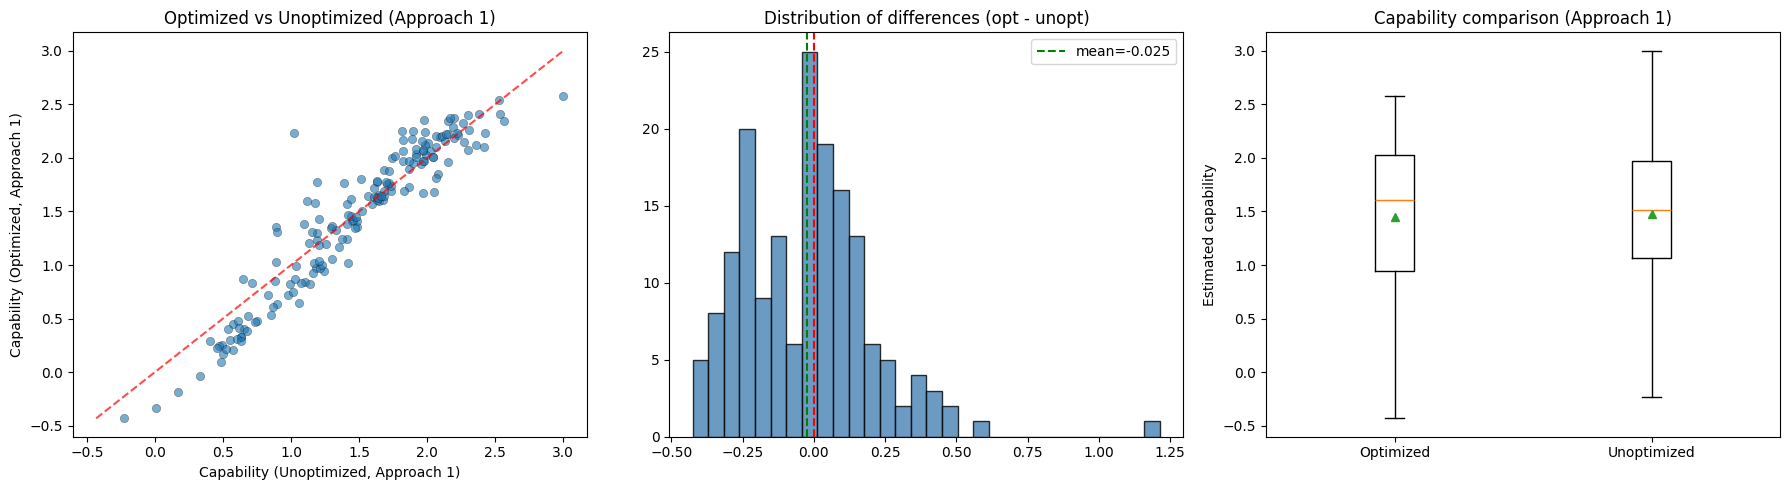

In [ ]:
# Build per-model comparison for Approach (1)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel, wilcoxon, pearsonr, spearmanr

# Safety: ensure we have data
assert (
    "opt_avg20" in globals() and "unopt_avg20" in globals()
), "Run Approach (1) cell first."

comp1 = (
    pd.DataFrame({"cap_opt20": opt_avg20, "cap_unopt20": unopt_avg20})
    .dropna(subset=["cap_opt20", "cap_unopt20"])
    .assign(
        diff=lambda d: d["cap_opt20"] - d["cap_unopt20"],
        ratio=lambda d: d["cap_opt20"] / d["cap_unopt20"],
    )
    .reset_index()
    .rename(columns={"index": "model"})
)

# Summary stats
t_stat, t_p = ttest_rel(comp1["cap_opt20"], comp1["cap_unopt20"])
w_stat, w_p = wilcoxon(comp1["cap_opt20"], comp1["cap_unopt20"])
r_pearson, p_pearson = pearsonr(comp1["cap_opt20"], comp1["cap_unopt20"])
r_spear, p_spear = spearmanr(comp1["cap_opt20"], comp1["cap_unopt20"])

summary1 = {
    "n_models_overlap": int(len(comp1)),
    "mean_diff": float(comp1["diff"].mean()),
    "median_diff": float(comp1["diff"].median()),
    "std_diff": float(comp1["diff"].std(ddof=0)),
    "t_pvalue": float(t_p),
    "wilcoxon_pvalue": float(w_p),
    "pearson_r": float(r_pearson),
    "spearman_rho": float(r_spear),
}
print({"approach": 1, **summary1})

# Top/bottom differences
print("\nTop 10 (opt - unopt):")
print(
    comp1.sort_values("diff", ascending=False)
    .head(10)[["model", "cap_opt20", "cap_unopt20", "diff"]]
    .to_string(index=False)
)
print("\nBottom 10 (opt - unopt):")
print(
    comp1.sort_values("diff", ascending=True)
    .head(10)[["model", "cap_opt20", "cap_unopt20", "diff"]]
    .to_string(index=False)
)

# Plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Scatter: unopt vs opt
axes[0].scatter(
    comp1["cap_unopt20"], comp1["cap_opt20"], alpha=0.6, edgecolors="k", linewidth=0.3
)
mn = min(comp1["cap_opt20"].min(), comp1["cap_unopt20"].min())
mx = max(comp1["cap_opt20"].max(), comp1["cap_unopt20"].max())
axes[0].plot([mn, mx], [mn, mx], "r--", alpha=0.7)
axes[0].set_xlabel("Capability (Unoptimized, Approach 1)")
axes[0].set_ylabel("Capability (Optimized, Approach 1)")
axes[0].set_title("Optimized vs Unoptimized (Approach 1)")

# Histogram of diffs
axes[1].hist(comp1["diff"], bins=30, color="steelblue", edgecolor="k", alpha=0.8)
axes[1].axvline(0, color="red", linestyle="--")
axes[1].axvline(
    comp1["diff"].mean(),
    color="green",
    linestyle="--",
    label=f"mean={comp1['diff'].mean():.3f}",
)
axes[1].set_title("Distribution of differences (opt - unopt)")
axes[1].legend()

# Boxplot
axes[2].boxplot(
    [comp1["cap_opt20"], comp1["cap_unopt20"]],
    labels=["Optimized", "Unoptimized"],
    showmeans=True,
)
axes[2].set_ylabel("Estimated capability")
axes[2].set_title("Capability comparison (Approach 1)")

plt.tight_layout()
plt.show()

# Export
out_dir = Path("outputs/benchmark_anchor_diff")
out_dir.mkdir(parents=True, exist_ok=True)
comp1.to_csv(out_dir / "approach1_model_capabilities.csv", index=False)

In [ ]:
# Rebuild Approach (1) outputs if Delta20 is missing, then define the two "actual" deltas

from pathlib import Path
import pandas as pd
import numpy as np

# Ensure the fitter helpers exist
assert (
    "fit_subset_with_benchmark_anchor_ref_init" in globals()
), "Define the reference-initialized fitter first."
assert "ensure_anchor_present" in globals(), "Define ensure_anchor_present first."

# Recompute Approach (1) if needed
if (
    "Delta20" not in globals()
    or "opt_avg20" not in globals()
    or "unopt_avg20" not in globals()
):
    # Partitions
    opt_df = scores_df[scores_df["optimized"]].copy()
    unopt_df = scores_df[~scores_df["optimized"]].copy()

    # Top-10 by coverage within each partition
    cov_opt = (
        opt_df.groupby("benchmark")["model"].nunique().sort_values(ascending=False)
    )
    cov_unopt = (
        unopt_df.groupby("benchmark")["model"].nunique().sort_values(ascending=False)
    )
    opt_anchors = cov_opt.head(10).index.tolist()
    unopt_anchors = cov_unopt.head(10).index.tolist()
    anchors20 = opt_anchors + unopt_anchors

    # Fit each anchor on both partitions (anchor enforced)
    opt_caps_by_anchor, unopt_caps_by_anchor = [], []
    for anc in anchors20:
        mcap_opt, _ = fit_subset_with_benchmark_anchor_ref_init(
            ensure_anchor_present(opt_df, anc), anc
        )
        mcap_unopt, _ = fit_subset_with_benchmark_anchor_ref_init(
            ensure_anchor_present(unopt_df, anc), anc
        )
        opt_caps_by_anchor.append(mcap_opt.set_index("model")["estimated_capability"])
        unopt_caps_by_anchor.append(
            mcap_unopt.set_index("model")["estimated_capability"]
        )

    # Average across anchors
    opt_avg20 = pd.concat(opt_caps_by_anchor, axis=1).mean(axis=1)
    unopt_avg20 = pd.concat(unopt_caps_by_anchor, axis=1).mean(axis=1)

    # Per-model differences on overlap
    common_models_20 = opt_avg20.index.intersection(unopt_avg20.index)
    Delta20 = opt_avg20.loc[common_models_20] - unopt_avg20.loc[common_models_20]

# Approach (1) actual delta
actual_delta1_mean = float(Delta20.mean())

In [ ]:
# Summary statistics for Approach (2) with normalized weights

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import ttest_rel, wilcoxon, pearsonr, spearmanr

# Given:
# - opt_avg_over_optAnch: mean capability on optimized data across optimized anchors
# - opt_avg_over_unoptAnch: mean capability on optimized data across unoptimized anchors
# - unopt_avg_over_optAnch: mean capability on unoptimized data across optimized anchors
# - unopt_avg_over_unoptAnch: mean capability on unoptimized data across unoptimized anchors
# - w_optAnch = num_unopt_total / num_total
# - w_unoptAnch = num_opt_total / num_total

# Presence masks
opt_has_optAnch = opt_avg_over_optAnch.notna().astype(float)
opt_has_unoptAnch = opt_avg_over_unoptAnch.notna().astype(float)
unopt_has_optAnch = unopt_avg_over_optAnch.notna().astype(float)
unopt_has_unoptAnch = unopt_avg_over_unoptAnch.notna().astype(float)

# Numerators
opt_num = (w_optAnch * opt_avg_over_optAnch).add(
    w_unoptAnch * opt_avg_over_unoptAnch, fill_value=0
)
unopt_num = (w_optAnch * unopt_avg_over_optAnch).add(
    w_unoptAnch * unopt_avg_over_unoptAnch, fill_value=0
)

# Denominators = sum of weights actually present per model
opt_den = (w_optAnch * opt_has_optAnch).add(
    w_unoptAnch * opt_has_unoptAnch, fill_value=0
)
unopt_den = (w_optAnch * unopt_has_optAnch).add(
    w_unoptAnch * unopt_has_unoptAnch, fill_value=0
)

# Normalized weighted capabilities (Approach 2, normalized)
opt_weighted_corr = (opt_num / opt_den).where(opt_den > 0)
unopt_weighted_corr = (unopt_num / unopt_den).where(unopt_den > 0)

# Build comp2_corr if not already present
if "comp2_corr" not in globals():
    assert (
        "opt_weighted_corr" in globals() and "unopt_weighted_corr" in globals()
    ), "Run the normalized weighting cell first."
    comp2_corr = (
        pd.DataFrame(
            {"cap_opt_w": opt_weighted_corr, "cap_unopt_w": unopt_weighted_corr}
        )
        .dropna()
        .assign(
            diff_w=lambda d: d["cap_opt_w"] - d["cap_unopt_w"],
            ratio_w=lambda d: d["cap_opt_w"] / d["cap_unopt_w"],
        )
        .reset_index()
        .rename(columns={"index": "model"})
    )

# Summary stats (paired)
t_stat2, t_p2 = ttest_rel(comp2_corr["cap_opt_w"], comp2_corr["cap_unopt_w"])
w_stat2, w_p2 = wilcoxon(comp2_corr["cap_opt_w"], comp2_corr["cap_unopt_w"])
r_pearson2, p_pearson2 = pearsonr(comp2_corr["cap_opt_w"], comp2_corr["cap_unopt_w"])
r_spear2, p_spear2 = spearmanr(comp2_corr["cap_opt_w"], comp2_corr["cap_unopt_w"])
diffs = comp2_corr["diff_w"].to_numpy()
cohen_d = diffs.mean() / diffs.std(ddof=1) if len(diffs) > 1 else np.nan

summary2_norm = {
    "approach": 2,
    "n_models_overlap": int(len(comp2_corr)),
    "mean_diff_weighted": float(diffs.mean()),
    "median_diff_weighted": float(np.median(diffs)),
    "std_diff_weighted": float(diffs.std(ddof=0)),
    "cohen_d_paired": float(cohen_d),
    "t_stat": float(t_stat2),
    "t_pvalue": float(t_p2),
    "wilcoxon_stat": float(w_stat2),
    "wilcoxon_pvalue": float(w_p2),
    "pearson_r": float(r_pearson2),
    "pearson_p": float(p_pearson2),
    "spearman_rho": float(r_spear2),
    "spearman_p": float(p_spear2),
}
print(summary2_norm)

# Top/bottom differences
print("\nTop 10 (opt - unopt, weighted - normalized):")
print(
    comp2_corr.sort_values("diff_w", ascending=False)
    .head(10)[["model", "cap_opt_w", "cap_unopt_w", "diff_w"]]
    .to_string(index=False)
)
print("\nBottom 10 (opt - unopt, weighted - normalized):")
print(
    comp2_corr.sort_values("diff_w", ascending=True)
    .head(10)[["model", "cap_opt_w", "cap_unopt_w", "diff_w"]]
    .to_string(index=False)
)

# Quick plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Scatter with y=x
axes[0].scatter(
    comp2_corr["cap_unopt_w"],
    comp2_corr["cap_opt_w"],
    alpha=0.6,
    edgecolors="k",
    linewidth=0.3,
)
mn = min(comp2_corr["cap_opt_w"].min(), comp2_corr["cap_unopt_w"].min())
mx = max(comp2_corr["cap_opt_w"].max(), comp2_corr["cap_unopt_w"].max())
axes[0].plot([mn, mx], [mn, mx], "r--", alpha=0.7)
axes[0].set_xlabel("Capability (Unoptimized, weighted - normalized)")
axes[0].set_ylabel("Capability (Optimized, weighted - normalized)")
axes[0].set_title("Optimized vs Unoptimized (Approach 2, normalized)")

# Histogram of diffs
axes[1].hist(comp2_corr["diff_w"], bins=30, color="coral", edgecolor="k", alpha=0.8)
axes[1].axvline(0, color="red", linestyle="--")
axes[1].axvline(
    comp2_corr["diff_w"].mean(),
    color="green",
    linestyle="--",
    label=f"mean={comp2_corr['diff_w'].mean():.3f}",
)
axes[1].set_title("Distribution of differences (weighted - normalized)")
axes[1].legend()

# Boxplot
axes[2].boxplot(
    [comp2_corr["cap_opt_w"], comp2_corr["cap_unopt_w"]],
    labels=["Optimized", "Unoptimized"],
    showmeans=True,
)
axes[2].set_ylabel("Estimated capability")
axes[2].set_title("Capability comparison (Approach 2, normalized)")

plt.tight_layout()
plt.show()

# Export
out_dir = Path("outputs/benchmark_anchor_diff")
out_dir.mkdir(parents=True, exist_ok=True)
comp2_corr.to_csv(
    out_dir / "approach2_model_capabilities_weighted_normalized.csv", index=False
)
with open(out_dir / "approach2_summary_weighted_normalized.txt", "w") as f:
    for k, v in summary2_norm.items():
        f.write(f"{k}: {v}\n")

In [ ]:
# Random benchmark partitions: compare actual opt vs unopt delta to random splits
# Requires:
# - fit_subset_with_benchmark_anchor_ref_init
# - ensure_anchor_present
# - Approach (1) variables: opt_df, unopt_df, Delta20 (per-model diffs)
# - Approach (2, normalized) variables: comp2_corr (with column 'diff_w')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# --- Actual deltas from earlier cells ---
actual_delta1_mean = float(Delta20.mean())  # Approach 1
actual_delta2_mean = float(comp2_corr["diff_w"].mean())  # Approach 2 (normalized)

# --- Partition sizes to match the real split ---
bench_meta = scores_df.drop_duplicates("benchmark")[["benchmark", "optimized"]]
num_opt_total = int(bench_meta[bench_meta["optimized"] == True]["benchmark"].nunique())
num_unopt_total = int(
    bench_meta[bench_meta["optimized"] == False]["benchmark"].nunique()
)
all_benchmarks_universe = bench_meta["benchmark"].tolist()
TOTAL_BENCH = num_opt_total + num_unopt_total

print(
    f"Using random partitions with sizes: A={num_opt_total}, B={num_unopt_total} (total={TOTAL_BENCH})"
)

# --- Helpers ---------------------------------------------------------------


def approach1_delta_mean_for_partition(
    partA: pd.DataFrame, partB: pd.DataFrame
) -> float:
    # Top-k anchors inside each partition by coverage
    covA = partA.groupby("benchmark")["model"].nunique().sort_values(ascending=False)
    covB = partB.groupby("benchmark")["model"].nunique().sort_values(ascending=False)
    kA = min(10, len(covA))
    kB = min(10, len(covB))
    anchorsA = covA.head(kA).index.tolist()
    anchorsB = covB.head(kB).index.tolist()
    anchors = anchorsA + anchorsB
    if not anchors:
        return np.nan

    # Fit both partitions for each anchor (anchor enforced in both)
    caps_A = []
    caps_B = []
    for anc in anchors:
        mcap_A, _ = fit_subset_with_benchmark_anchor_ref_init(
            ensure_anchor_present(partA, anc), anc
        )
        mcap_B, _ = fit_subset_with_benchmark_anchor_ref_init(
            ensure_anchor_present(partB, anc), anc
        )
        caps_A.append(mcap_A.set_index("model")["estimated_capability"])
        caps_B.append(mcap_B.set_index("model")["estimated_capability"])

    A_avg = pd.concat(caps_A, axis=1).mean(axis=1)
    B_avg = pd.concat(caps_B, axis=1).mean(axis=1)
    overlap = A_avg.index.intersection(B_avg.index)
    if len(overlap) == 0:
        return np.nan
    return float((A_avg.loc[overlap] - B_avg.loc[overlap]).mean())


def normalized_weighted_side(
    avg_over_group1: pd.Series,
    avg_over_group2: pd.Series,
    w_group1: float,
    w_group2: float,
) -> pd.Series:
    # Normalize by available weights per model
    has1 = avg_over_group1.notna().astype(float)
    has2 = avg_over_group2.notna().astype(float)
    num = (w_group1 * avg_over_group1).add(w_group2 * avg_over_group2, fill_value=0)
    den = (w_group1 * has1).add(w_group2 * has2, fill_value=0)
    return (num / den).where(den > 0)


def approach2_delta_mean_for_partition(
    partA: pd.DataFrame, partB: pd.DataFrame
) -> float:
    # All anchors partitioned by which side they belong to (like “opt-like” vs “unopt-like”)
    anchorsA = partA["benchmark"].drop_duplicates().tolist()
    anchorsB = partB["benchmark"].drop_duplicates().tolist()

    # Fit all anchors on both sides (anchor enforced in that side’s df when missing)
    A_caps_from_A, A_caps_from_B = [], []
    B_caps_from_A, B_caps_from_B = [], []

    # Weights per spec: weight of the OTHER side’s count
    wA = (
        len(anchorsB) / (len(anchorsA) + len(anchorsB))
        if (anchorsA or anchorsB)
        else 0.0
    )
    wB = (
        len(anchorsA) / (len(anchorsA) + len(anchorsB))
        if (anchorsA or anchorsB)
        else 0.0
    )

    # From A-anchors
    for anc in anchorsA:
        mcap_A, _ = fit_subset_with_benchmark_anchor_ref_init(
            ensure_anchor_present(partA, anc), anc
        )
        mcap_B, _ = fit_subset_with_benchmark_anchor_ref_init(
            ensure_anchor_present(partB, anc), anc
        )
        sA = mcap_A.set_index("model")["estimated_capability"]
        sB = mcap_B.set_index("model")["estimated_capability"]
        A_caps_from_A.append(sA)
        B_caps_from_A.append(sB)

    # From B-anchors
    for anc in anchorsB:
        mcap_A, _ = fit_subset_with_benchmark_anchor_ref_init(
            ensure_anchor_present(partA, anc), anc
        )
        mcap_B, _ = fit_subset_with_benchmark_anchor_ref_init(
            ensure_anchor_present(partB, anc), anc
        )
        sA = mcap_A.set_index("model")["estimated_capability"]
        sB = mcap_B.set_index("model")["estimated_capability"]
        A_caps_from_B.append(sA)
        B_caps_from_B.append(sB)

    def _avg(series_list: list[pd.Series]) -> pd.Series:
        if not series_list:
            return pd.Series(dtype=float)
        return pd.concat(series_list, axis=1).mean(axis=1)

    A_avg_over_A = _avg(A_caps_from_A)
    A_avg_over_B = _avg(A_caps_from_B)
    B_avg_over_A = _avg(B_caps_from_A)
    B_avg_over_B = _avg(B_caps_from_B)

    # Normalized weighted combination per side
    A_weighted = normalized_weighted_side(A_avg_over_A, A_avg_over_B, wA, wB)
    B_weighted = normalized_weighted_side(B_avg_over_A, B_avg_over_B, wA, wB)

    overlap = A_weighted.index.intersection(B_weighted.index)
    if len(overlap) == 0:
        return np.nan
    return float((A_weighted.loc[overlap] - B_weighted.loc[overlap]).mean())


# --- Random partitions driver ---------------------------------------------


def run_random_partitions(n_partitions: int = 200, seed: int = 123):
    rng = np.random.default_rng(seed)
    A_size = num_opt_total
    all_bench = all_benchmarks_universe

    deltas_app1, deltas_app2 = [], []

    for _ in range(n_partitions):
        # Sample A benchmarks; B is complement
        if A_size <= 0 or A_size >= len(all_bench):
            continue
        A_bench = rng.choice(all_bench, size=A_size, replace=False)
        A_bench = set(map(str, A_bench))
        partA = scores_df[scores_df["benchmark"].isin(A_bench)].copy()
        partB = scores_df[~scores_df["benchmark"].isin(A_bench)].copy()

        # Skip tiny partitions
        if partA["benchmark"].nunique() < 2 or partB["benchmark"].nunique() < 2:
            continue

        # Approach 1
        try:
            d1 = approach1_delta_mean_for_partition(partA, partB)
        except Exception:
            d1 = np.nan

        # Approach 2 (normalized)
        try:
            d2 = approach2_delta_mean_for_partition(partA, partB)
        except Exception:
            d2 = np.nan

        deltas_app1.append(d1)
        deltas_app2.append(d2)

    return np.array(deltas_app1, dtype=float), np.array(deltas_app2, dtype=float)


# --- Run and summarize -----------------------------------------------------

rand_app1, rand_app2 = run_random_partitions(n_partitions=2, seed=123)


def summarize_random_vs_actual(random_vals: np.ndarray, actual_val: float, label: str):
    rv = random_vals[np.isfinite(random_vals)]
    print(f"\n{label}: {len(rv)} successful partitions")
    if len(rv) == 0:
        return
    mean, std = float(rv.mean()), float(rv.std())
    pct = float((rv < actual_val).mean() * 100.0)
    print(f"  Random mean ± std: {mean:.4f} ± {std:.4f}")
    print(f"  Actual delta mean: {actual_val:.4f}")
    print(f"  Percentile (random < actual): {pct:.1f}th")

    # Plot
    plt.figure(figsize=(7, 4))
    plt.hist(rv, bins=30, alpha=0.8, color="steelblue", edgecolor="k")
    plt.axvline(
        actual_val,
        color="red",
        linestyle="--",
        linewidth=2,
        label=f"Actual: {actual_val:.3f}",
    )
    plt.title(f"{label}: Random partitions vs Actual")
    plt.xlabel("Delta mean (A - B)")
    plt.ylabel("Frequency")
    plt.legend()
    plt.tight_layout()
    plt.show()


# Compare
summarize_random_vs_actual(
    rand_app1, actual_delta1_mean, "Approach 1 (top-10+10 anchors)"
)
summarize_random_vs_actual(
    rand_app2, actual_delta2_mean, "Approach 2 (normalized weighting)"
)

# Save
out_dir = Path("outputs/benchmark_anchor_diff")
out_dir.mkdir(parents=True, exist_ok=True)
np.savetxt(
    out_dir / "random_partitions_approach1_delta_means.txt",
    rand_app1[np.isfinite(rand_app1)],
)
np.savetxt(
    out_dir / "random_partitions_approach2_delta_means.txt",
    rand_app2[np.isfinite(rand_app2)],
)
with open(out_dir / "random_partitions_summary.txt", "w") as f:
    f.write(f"Approach 1 actual: {actual_delta1_mean:.6f}\n")
    f.write(f"Approach 2 (normalized) actual: {actual_delta2_mean:.6f}\n")
    f.write(f"Approach 1 random N: {np.isfinite(rand_app1).sum()}\n")
    f.write(f"Approach 2 random N: {np.isfinite(rand_app2).sum()}\n")